In [138]:
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data import ee_utils
from src.data import fire_perimeters
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
import seaborn as sns
from src.data import shape_processor


sns.set_theme()

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(ee_utils)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)

2023-06-17 18:00:10,423 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-17 18:00:10,425 DEBUG: Logger /home/jk871/fire-regen/src/data/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-17 18:00:10,426 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-17 18:00:10,428 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

In [49]:
ee.Authenticate()


Successfully saved authorization token.


In [14]:
ee.Initialize()

In [2]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_9(3)

In [3]:
gedi_burned = gedi_burned[gedi_burned.burn_count == 1]

In [4]:
mtbs_perimeters = gpd.read_file(f"{DATA_PATH}/mtbs/mtbs_perims_DD.shp")

In [5]:
sierras_complex = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras.shp")
sierras_box = shape_processor.get_box(sierras_complex)
sierras = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras_convex_hull.shp")
sierras_4269 = sierras_box.to_crs(4269)

In [6]:
sierrap = mtbs_perimeters.sjoin(sierras_4269, how="inner", predicate="within")
sierrap.drop(columns="index_right", inplace=True)

In [9]:
sierrap = sierrap.to_crs(4326)

In [55]:
sierrap["Ig_Date"] = pd.to_datetime(sierrap.Ig_Date)

In [36]:
for perimeter in sierrap.itertuples():
    fire = sierrap[sierrap.index == perimeter.Index]
    gedi_windy = gedi_burned.sjoin(fire, how="inner", predicate="within")
    print(fire.index)
    print(gedi_windy.burn_year.unique())

Index([3], dtype='int64')
[]
Index([18], dtype='int64')
[]
Index([20], dtype='int64')
[]
Index([21], dtype='int64')
[]
Index([22], dtype='int64')
[]
Index([23], dtype='int64')
[]
Index([27], dtype='int64')
[]
Index([29], dtype='int64')
[]
Index([34], dtype='int64')
[]
Index([46], dtype='int64')
[]
Index([52], dtype='int64')
[]
Index([53], dtype='int64')
[]
Index([54], dtype='int64')
[]
Index([60], dtype='int64')
[1994.]
Index([62], dtype='int64')
[]
Index([66], dtype='int64')
[]
Index([73], dtype='int64')
[]
Index([74], dtype='int64')
[1984.]
Index([75], dtype='int64')
[1984.]
Index([76], dtype='int64')
[]
Index([77], dtype='int64')
[]
Index([78], dtype='int64')
[]
Index([79], dtype='int64')
[]
Index([80], dtype='int64')
[]
Index([82], dtype='int64')
[]
Index([87], dtype='int64')
[1984.]
Index([92], dtype='int64')
[]
Index([93], dtype='int64')
[]
Index([94], dtype='int64')
[]
Index([96], dtype='int64')
[]
Index([97], dtype='int64')
[]
Index([98], dtype='int64')
[]
Index([102], dtype='i

In [125]:
sierrap.shape[0]

1342

In [ ]:
sierrap[sierrap]

In [139]:
results = regen_analysis.match_with_proximity_matrix(sierrap)

Processing fires in year 1985
Processing fire 459    ADELAIDE
Name: Incid_Name, dtype: object
No matching burn shots
Processing fire 477    SKEDADDLE
Name: Incid_Name, dtype: object
No matching burn shots
Processing fire 478    QUINN
Name: Incid_Name, dtype: object
No matching burn shots
Processing fire 483    SOU HILLS
Name: Incid_Name, dtype: object
No matching burn shots
Processing fire 485    BUMB
Name: Incid_Name, dtype: object
No matching burn shots
Processing fire 503    WIZARD
Name: Incid_Name, dtype: object
No matching burn shots
Processing fire 509    PONOCHE 2
Name: Incid_Name, dtype: object
No matching burn shots
Processing fire 510    PINEY CREEK
Name: Incid_Name, dtype: object
No matching burn shots
Processing fire 512    ROCK CREEK
Name: Incid_Name, dtype: object
Processing fire 527    DRY VALLEY
Name: Incid_Name, dtype: object
No matching burn shots
Processing fire 533    KNOTT CK.
Name: Incid_Name, dtype: object
No matching burn shots
Processing fire 534    AMAX 1
Name

In [147]:
res_filt = results[results.burn_count == 1]

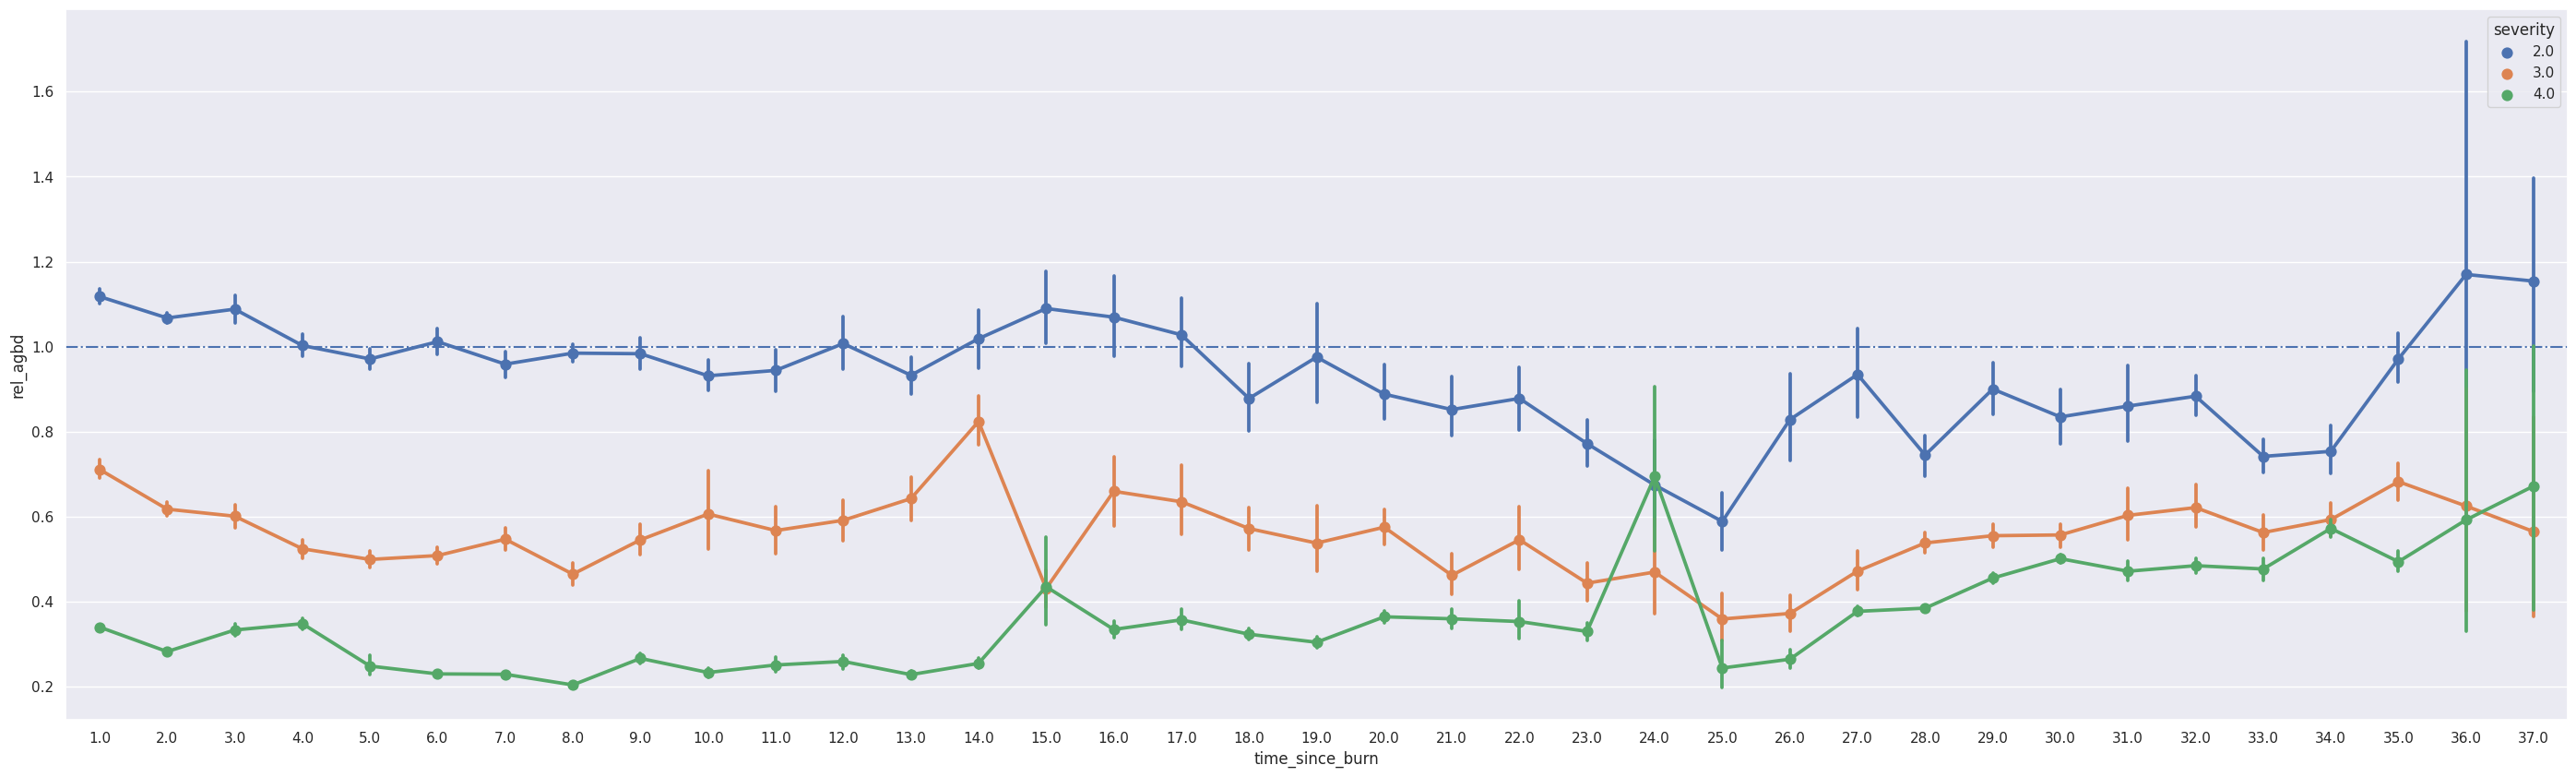

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(res_filt, x='time_since_burn', y='rel_agbd', hue='severity')
ax.axhline(y=1, linestyle="-.")

In [145]:
results.shape[0]

242451

In [141]:
save_pickle(f"{DATA_PATH}/rf/results_from_10_fires_mean.pkl", results)

In [136]:
sierrap["fire_year"] = sierrap.Ig_Date.dt.year

In [137]:
sierrap["fire_year"]

3        1984
18       1984
20       1984
21       1984
22       1984
         ... 
29428    2021
29429    2021
29430    2021
29431    2021
29823    2021
Name: fire_year, Length: 1342, dtype: int32

In [130]:
fire = sierrap[sierrap.index == 4941]

In [132]:
fire = fire_perimeters.MTBSFire(fire)

In [133]:
fire.fire.Ig_Date.dt.year.iloc[0]

1994

In [135]:
from fastai.tabular.all import load_pickle
import pickle
import numpy as np

def match_with_unburned_control_using_rf(fire):
    model_path = f"{DATA_PATH}/rf/models_shallow"
    inference_path = f"{DATA_PATH}/rf/burned/3x3"
    unburned_path = f"{DATA_PATH}/rf/unburned_B"

    year = fire.fire.Ig_Date.dt.year.iloc[0]

    m = load_pickle(f"{model_path}/model_{year}.pkl")
    to = pickle.load(open(f"{model_path}/to_{year}.pkl", 'rb'))
    gedi_burned = load_pickle(f"{inference_path}/gedi_match_{year}.pkl")
    gedi_unburned = load_pickle(f"{unburned_path}/gedi_match_{year}.pkl")

    buffer = fire.get_buffer(5000, 100)
    within_buffer = gedi_unburned.sjoin(buffer, how="inner", predicate="within")
    within_fire = gedi_burned[gedi_burned.burn_year == year].sjoin(fire.fire, how="inner", predicate="within")

    print(len(within_buffer))
    print(len(within_fire))
    to_burned = to.train.new(within_fire)
    to_burned.process()

    to_unburned = to.train.new(within_buffer)
    to_unburned.process()

    terminals_burned = m.apply(to_burned.train.xs)
    terminals_unburned = m.apply(to_unburned.train.xs)

    a = terminals_burned[:, 0]
    b = terminals_unburned[:, 0]

    proxMat = 1*np.equal.outer(a, b)

    for i in range(1, 100):
        a = terminals_burned[:, i]
        b = terminals_unburned[:, i]
        proxMat += 1*np.equal.outer(a, b)

    proxMat = proxMat / 100

    proxMat_max = np.argsort(proxMat, axis=1)[:, -10:]

    control_agbd = np.empty(proxMat_max.shape[0])
    for i in range(0, proxMat_max.shape[0]):
        control_agbd[i] = within_buffer.iloc[proxMat_max[i, :]].agbd.mean()

    within_fire["control_agbd"] = control_agbd
    within_fire["rel_agbd"] = within_fire.agbd / within_fire.control_agbd

    return within_fire


    #print(len(within_buffer), len(within_fire))


proxMat = match_with_unburned_control_using_rf(fire)

0
1


ValueError: Found array with 0 sample(s) (shape=(0, 76)) while a minimum of 1 is required by RandomForestRegressor.

In [122]:
proxMat

shot_number   longitude   latitude        agbd  \
11983524  140710500300291232 -118.613174  36.962293   29.203600   
18651586  140710500300291233 -118.612690  36.961954   27.389645   
18651587  140710500300291235 -118.611722  36.961275   24.992018   
18651688   61060800200127301 -118.612450  36.961933   24.950138   
18651803  140711100300290684 -118.631703  36.950776  263.088440   
18651804  140711100300290685 -118.631217  36.950437   47.964176   
18651805  140711100300290686 -118.630731  36.950099   36.082005   
18651825   90800000200156430 -118.632091  36.949394   86.127205   
18651826   90800000200156431 -118.631624  36.949721   21.865578   
18651827   90800000200156432 -118.631151  36.950052   59.340408   
18651828   90800000200156433 -118.630692  36.950371   59.828262   
18651829   90800000200156434 -118.630234  36.950689   80.412422   
18651831   90800000200156436 -118.629321  36.951324   85.347122   
18651933   61060800200127262 -118.631164  36.948853   30.482716   
18651934   61060800200127263 -118.630687  36.949185   24.389740   
18651935   61060800200127264 -118.630208  36.949519   44.872128   
18657223   61060600200402518 -118.618238  36.966134   25.091330   
18657289  140710600300528662 -118.626441  36.964367   19.827623   

          agbd_pi_lower  agbd_pi_upper    agbd_se beam_type  sensitivity  \
11983524   -9999.000000     118.551689  11.105848      full     0.984094   
18651586   -9999.000000     114.874702  11.107232      full     0.975249   
18651587   -9999.000000     109.907501  11.107337      full     0.953626   
18651688   -9999.000000     109.819695  11.107342      full     0.975307   
18651803     114.998055     471.597229  11.155227      full     0.989440   
18651804       2.079952     153.984055  11.103032      full     0.988632   
18651805       0.273370     132.038742  11.105333      full     0.973800   
18651825      14.419675     217.964615  11.101966  coverage     0.963127   
18651826   -9999.000000     103.244118  11.108839  coverage     0.973543   
18651827       4.928880     173.882126  11.102024  coverage     0.962917   
18651828       5.071003     174.711746  11.101295  coverage     0.971295   
18651829      12.142733     208.801147  11.099963  coverage     0.967914   
18651831      14.105263     216.707962  11.099955  coverage     0.959272   
18651933       0.001375     121.113365  11.105555      full     0.973110   
18651934   -9999.000000     108.639915  11.107233      full     0.984744   
18651935       1.476852     148.402939  11.103010      full     0.972931   
18657223   -9999.000000     110.114082  11.107032      full     0.968298   
18657289   -9999.000000      98.764748  11.110363      full     0.960253   

          pft_class  ...  dNBR_offst  dNBR_stdDv NoData_T IncGreen_T  Low_T  \
11983524          1  ...          -8       -9999     -970       -150    105   
18651586          1  ...          -8       -9999     -970       -150    105   
18651587          1  ...          -8       -9999     -970       -150    105   
18651688          1  ...          -8       -9999     -970       -150    105   
18651803          1  ...          -8       -9999     -970       -150    105   
18651804          1  ...          -8       -9999     -970       -150    105   
18651805          1  ...          -8       -9999     -970       -150    105   
18651825          1  ...          -8       -9999     -970       -150    105   
18651826          1  ...          -8       -9999     -970       -150    105   
18651827          1  ...          -8       -9999     -970       -150    105   
18651828          1  ...          -8       -9999     -970       -150    105   
18651829          1  ...          -8       -9999     -970       -150    105   
18651831          1  ...          -8       -9999     -970       -150    105   
18651933          1  ...          -8       -9999     -970       -150    105   
18651934          1  ...          -8       -9999     -970       -150    105   
18651935          1  ...          

In [90]:
proxMat

array([[0.01, 0.  , 0.  , ..., 0.01, 0.14, 0.05],
       [0.01, 0.  , 0.  , ..., 0.01, 0.24, 0.06],
       [0.  , 0.  , 0.  , ..., 0.  , 0.1 , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.18, 0.12, 0.  , ..., 0.22, 0.01, 0.04],
       [0.09, 0.07, 0.  , ..., 0.07, 0.01, 0.17]])

In [86]:
np.max(proxMat, axis=1)

array([0.67, 0.77, 0.78, 0.75, 0.82, 0.64, 0.75, 0.4 , 0.55, 0.59, 0.7 ,
       0.56, 0.78, 0.74, 0.66, 0.87, 0.71, 0.79])

In [101]:
np.argsort(proxMat, axis=1)

array([[ 501, 1306,  625, ...,  673,  815,  953],
       [ 521,  647,  650, ...,  541, 1087,  673],
       [   0, 1078, 1077, ...,   47, 1397,   39],
       ...,
       [   0, 1204, 1203, ...,  496,  916,  525],
       [1254, 1711,  616, ..., 1084,  649,  272],
       [1586,  738,  739, ..., 1200, 1624,  841]])

In [104]:
np.argsort(proxMat, axis=1)[:, -10:]

array([[1344, 1730,  351,  615, 1797,  541, 1688,  673,  815,  953],
       [ 351, 1656,  952, 1344,  189,  815,  610,  541, 1087,  673],
       [1230, 1052, 1571, 1236, 1053,  341, 1369,   47, 1397,   39],
       [ 351,  815, 1795,  541, 1344,  673,  610,  952,  189, 1087],
       [1480,  910,  587, 1342,  556,  191,  526,  555, 1633, 1634],
       [ 885, 1398,  525,  820,  556, 1633,  555,  526,  883, 1634],
       [ 409,  497, 1216,  525, 1218,   67,  496,  909,  916,  907],
       [1225, 1289,   67,  916,  497, 1224, 1216,  909, 1218,  907],
       [1225, 1289, 1224,  916,   67,  497,  909, 1216, 1218,  907],
       [1216, 1218, 1235,   67,  409,  525,  909,  496,  916,  907],
       [1216, 1235,  409, 1218,  525,   67,  496,  916,  909,  907],
       [ 496,   67, 1224, 1289, 1216, 1218, 1225, 1217,  907,  497],
       [1444, 1504, 1657,  252, 1300, 1091,  211, 1503,  212,  210],
       [ 188,  190, 1480,  910,  587,  191, 1634, 1342,  556, 1633],
       [ 419, 1398, 1237,  555, 16

In [98]:
np.sum(proxMat > 0.1, axis=1)

array([431, 385, 318, 314, 108, 104,  21,  15,  16,  31,  26,  10, 556,
       141,  82,  48, 538, 353])

In [42]:
gedi_fire = gedi_burned.sjoin(fire, how="inner", predicate="within")

In [25]:
gedi = gedi_pipeline.load_stage_3(3)

In [43]:
gedi_fire_3 = gedi.sjoin(fire, how="inner", predicate="within")

<Axes: >

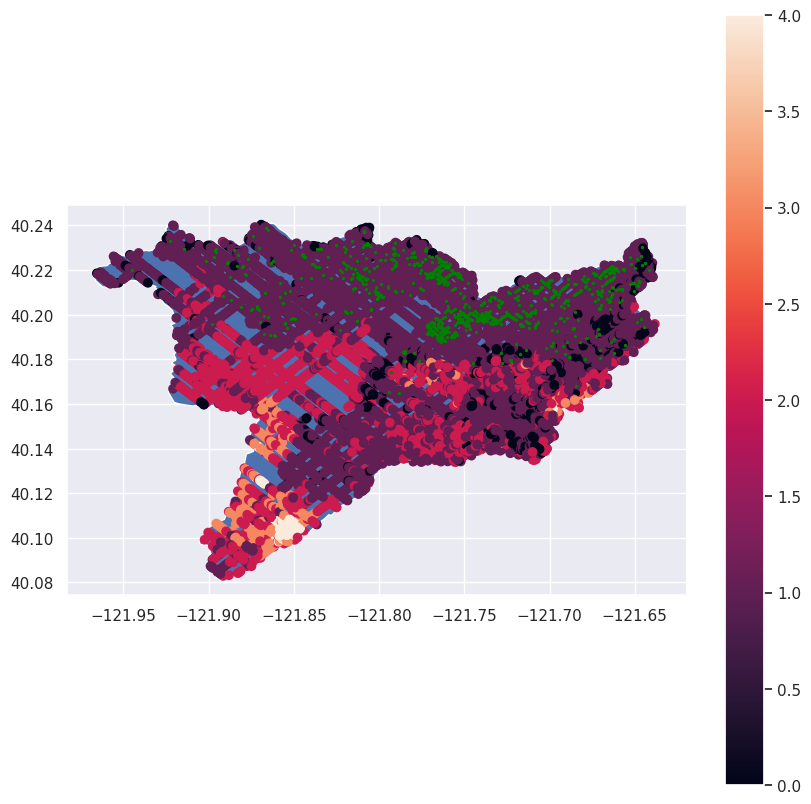

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fire.plot(ax=ax)
gedi_fire_3[(gedi_fire_3.burn_year_std == 0)].plot(ax=ax, column="burn_counts_median", legend=True)
gedi_fire.plot(ax=ax, column="time_since_burn", color="green", markersize=2)

<Axes: >

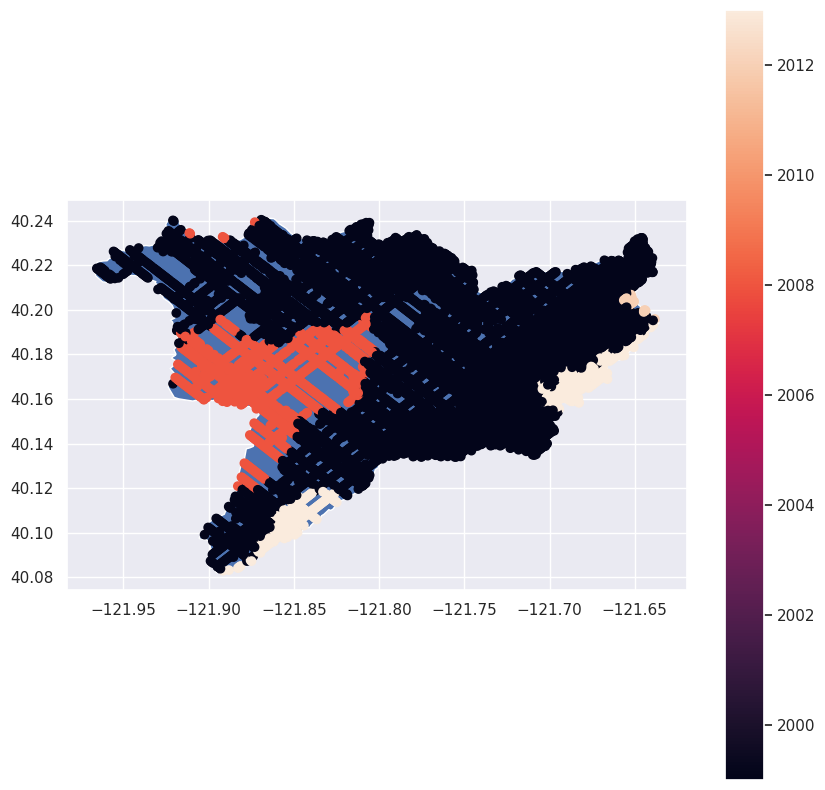

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fire.plot(ax=ax)
gedi_fire_3[gedi_fire_3.burn_year_std == 0].plot(ax=ax, column="burn_year_median", legend=True)

In [15]:
from src.visualization import ee_viz

In [17]:
from src.data import mtbs

burn_sev = mtbs.get_aggregated_burn_data()

In [18]:
ee_viz.viz_burn_severity(burn_sev, fire.geometry.iloc[0], ['last_burn_severity', 'last_burn_year', 'burn_count'])

Map(center=[35.80405732198009, -118.52626099753896], controls=(WidgetControl(options=['position', 'transparent…

In [46]:
burn_1999 = mtbs.get_burn_severity_data_for_year(1999)
burn_2013 = mtbs.get_burn_severity_data_for_year(2013)

In [47]:
ee_viz.viz_burn_severity(burn_1999, fire.geometry.iloc[0], ['burn_severity', 'burn_year'])

Map(center=[40.17864973828209, -121.80406314599405], controls=(WidgetControl(options=['position', 'transparent…

In [38]:
gedi_fire = gedi_burned.sjoin(fire, how="inner", predicate="within")

<Axes: xlabel='time_since_burn', ylabel='Count'>

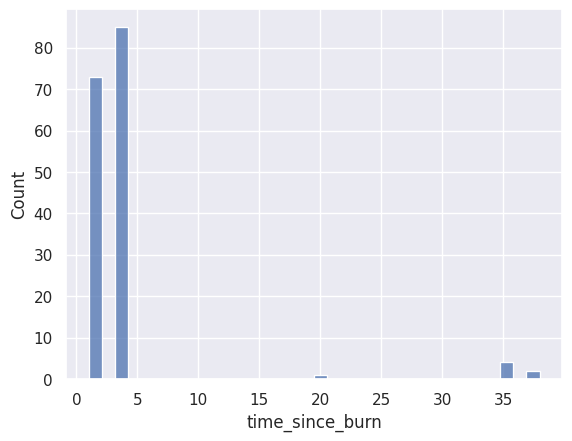

In [40]:
sns.histplot(gedi_fire.time_since_burn)

In [28]:
windy = sierra_perimeters[sierra_perimeters.Incid_Name == "WINDY"]

In [30]:
gedi_windy = gedi_burned.sjoin(windy, how="inner", predicate="within")

In [33]:
gedi_windy.time_since_burn.unique()

array([1.])

<Axes: >

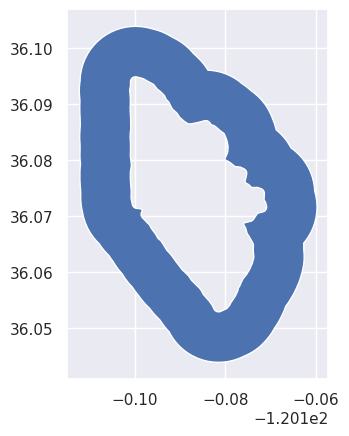

In [24]:
\fire.get_buffer(1000).plot()

### Filter for tiny fires

In [2]:
sierras = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras_convex_hull.shp")
firep_db = FirePerimetersDB(f"{USER_PATH}/data/fire_perimeters.gdb/")
sierra_firep = FirePerimeters(firep_db).filter_within_geometry(sierras)

In [3]:
perimeters = sierra_firep.perimeters

In [ ]:
perimeters[]

In [18]:
perimeters["area_acres"] = perimeters.Shape_Area / 4047

In [4]:
creek = perimeters[perimeters.index == 241]

In [31]:
(perimeters.area_acres > 900).sum()

1443

In [ ]:
perimeters[perimeters.]

In [24]:
gedi_matched.shape

(218923, 23)

In [23]:
gedi_filtered = gedi_matched.copy()
for perimeter in perimeters[perimeters.area_acres < 900].itertuples():
    fire = perimeters[perimeters.index == perimeter.Index]

    gedi_filtered = gedi_filtered[~gedi_filtered.index.isin(gedi_filtered.sjoin(fire, how="inner", predicate="within").index)]
gedi_filtered

shot_number   longitude   latitude        agbd  \
68233      42640600300521207 -120.750616  38.172525   27.992105   
70255     191910500200119943 -120.740033  38.155407  123.460587   
72312      81650600200449990 -120.754568  38.096837   16.602076   
72313      81650600200449991 -120.754079  38.097166   18.214243   
73150     225021100200119926 -120.738474  38.154606   83.151505   
...                      ...         ...        ...         ...   
27618963  225630800200085757 -119.553059  38.564323  122.198563   
27618964  225630800200085760 -119.551527  38.565317   28.583668   
27618967  225630800200085764 -119.549511  38.566621   20.807606   
27618975  225631100200080331 -119.554363  38.556271  131.316925   
27624050  156220200200085334 -119.406297  38.528133   31.825970   

          agbd_pi_lower  agbd_pi_upper    agbd_se beam_type  sensitivity  \
68233          5.854515      66.616653   2.982341      full     0.972790   
70255         31.679453     275.364624  11.100678      full     0.988443   
72312      -9999.000000      91.402557  11.113122      full     0.958655   
72313      -9999.000000      95.125694  11.111183      full     0.961252   
73150         13.214792     213.226410  11.103502      full     0.984161   
...                 ...            ...        ...       ...          ...   
27618963      31.039167     273.485962  11.101624      full     0.988854   
27618964   -9999.000000     117.301216  11.106215      full     0.983052   
27618967   -9999.000000     100.928558  11.108585      full     0.968726   
27618975      35.723694     287.024231  11.099050      full     0.994654   
27624050       0.024733     123.779739  11.106153  coverage     0.951131   

          pft_class  ...                     geometry  severity burn_year  \
68233             6  ...  POINT (-120.75062 38.17252)       2.0    1985.0   
70255             1  ...  POINT (-120.74003 38.15541)       2.0    1985.0   
72312             1  ...  POINT (-120.75457 38.09684)       4.0    1985.0   
72313             1  ...  POINT (-120.75408 38.09717)       4.0    1985.0   
73150             1  ...  POINT (-120.73847 38.15461)       2.0    1985.0   
...             ...  ...                          ...       ...       ...   
27618963          1  ...  POINT (-119.55306 38.56432)       2.0    2020.0   
27618964          1  ...  POINT (-119.55153 38.56532)       2.0    2020.0   
27618967          1  ...  POINT (-119.54951 38.56662)       3.0    2020.0   
27618975          1  ...  POINT (-119.55436 38.55627)       2.0    2020.0   
27624050          1  ...  POINT (-119.40630 38.52813)       4.0    2020.0   

         burn_count  time_since_burn    elevation      slope      aspect  \
68233           1.0             34.0   387.555556  24.000000   57.222222   
70255           1.0             37.0   539.000000  20.000000   48.666667   
72312           1.0             35.0   345.000000   8.000000  185.000000   
72313           1.0             35.0   354.222222  10.222222  197.222222   
73150           1.0             37.0   512.333333  25.333333   51.666667   
...             ...              ...          ...        ...         ...   
27618963        1.0              2.0  2090.000000  30.666667  289.666667   
27618964        1.0              2.0  2126.000000  25.333333  301.333333   
27618967        1.0              2.0  2134.333333  11.333333    9.666667   
27618975        1.0              2.0  2144.333333  29.666667  278.333333   
27624050        1.0              1.0  2419.333333  16.333333  228.000000   

          soil  agbd_control  
68233      0.0    112.240336  
70255      0.0    102.150819  
72312      0.0     67.179398  
72313      0.0     75.308522  
73150      0.0     97.818172  
...        ...           ...  
27618963  19.0     99.695585  
27618964  19.0     80.235779  
27618967  19.0     72.595643  
27618975  19.0    118.468859  
27624050  19.0     54.550584  

[207537 rows x 23 columns]

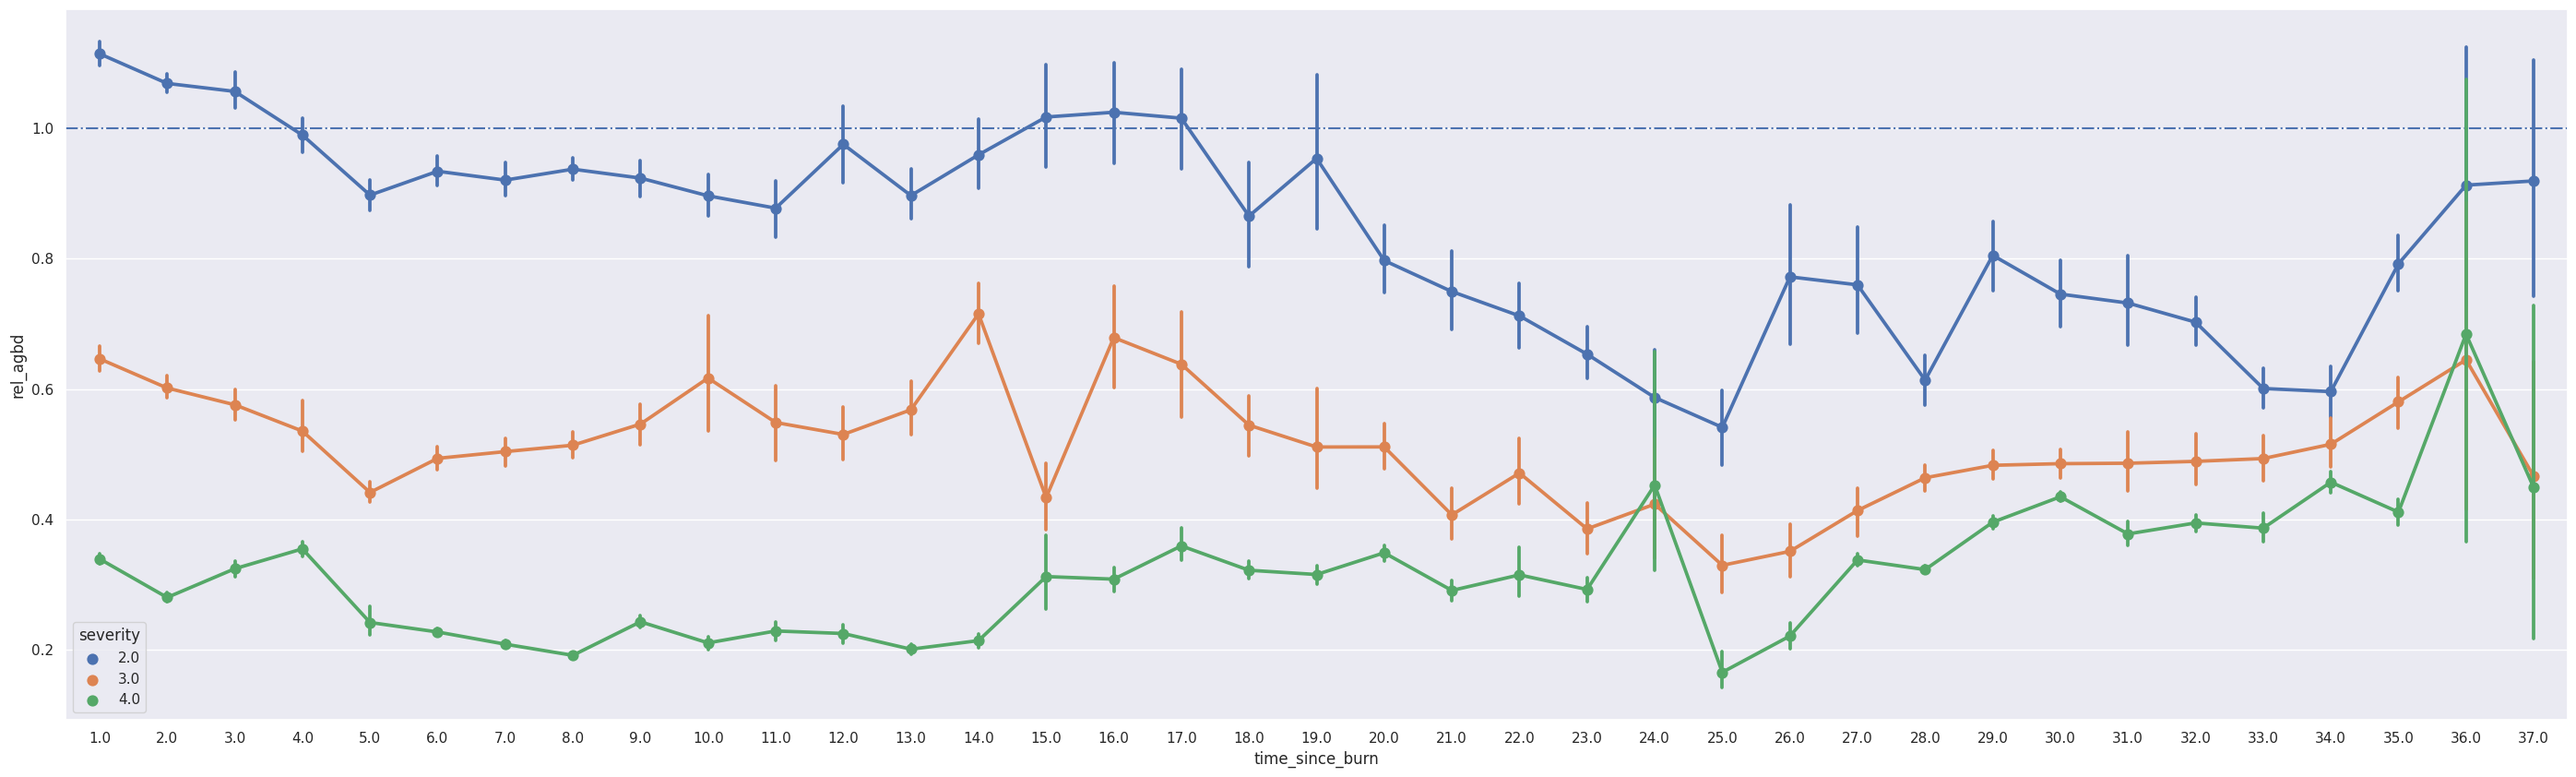

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_filtered, x='time_since_burn', y='rel_agbd', hue='severity')
ax.axhline(y=1, linestyle="-.")

(0.0, 1.2)

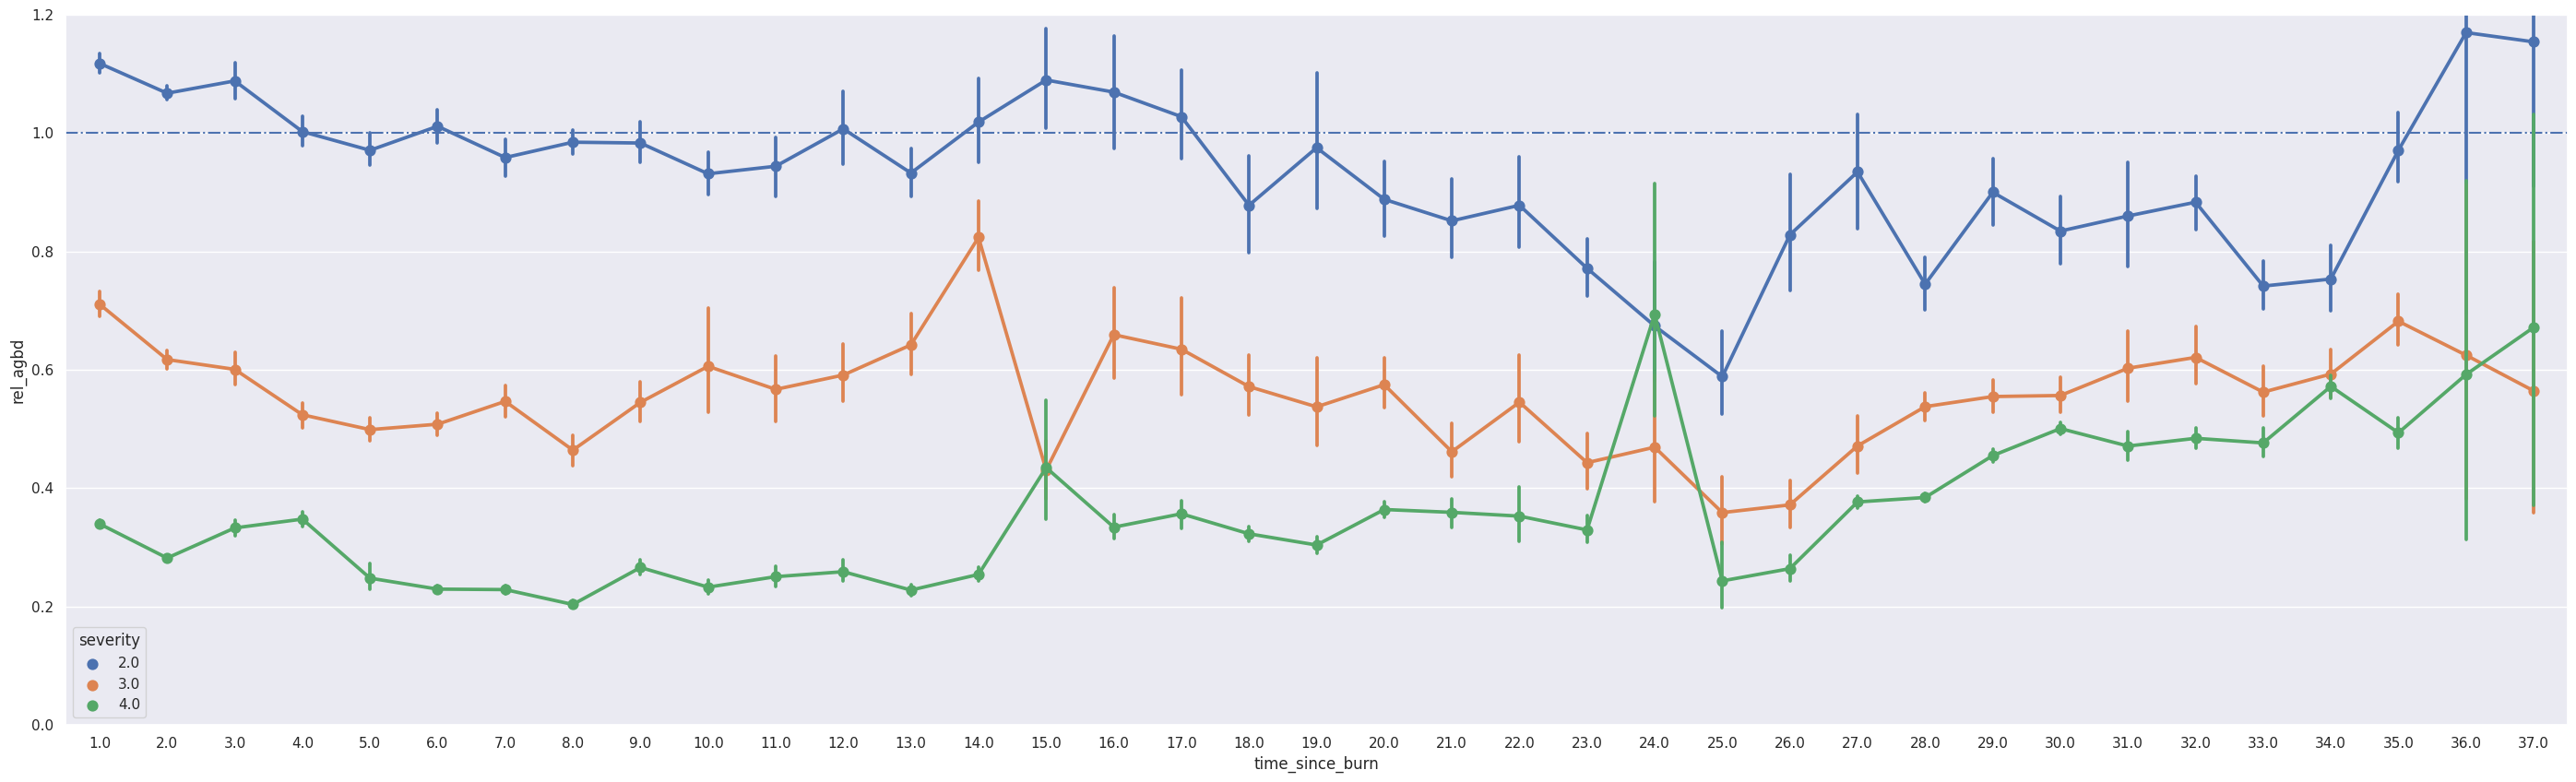

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(res_filt, x='time_since_burn', y='rel_agbd', hue='severity')
ax.axhline(y=1, linestyle="-.")
ax.set_ylim((0, 1.2))

115785


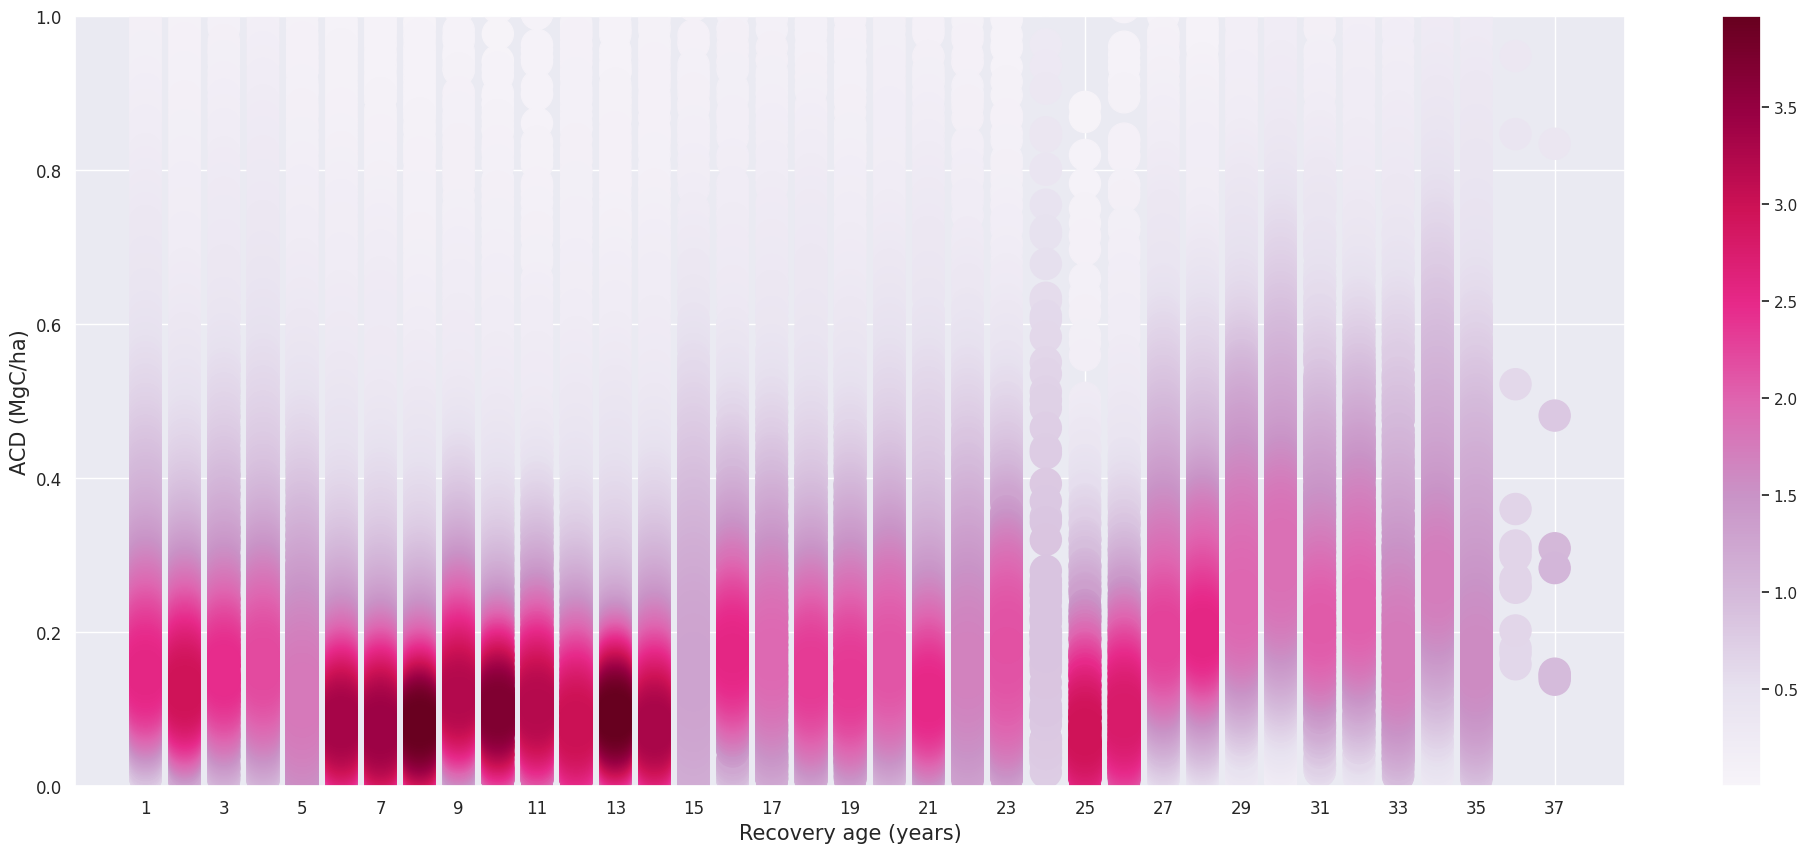

In [30]:
plot_pdf(gedi_filtered[gedi_filtered.severity == 4],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 1))

In [27]:
gedi_filtered['rel_agbd'] = gedi_filtered.agbd / gedi_filtered.agbd_control

<Axes: >

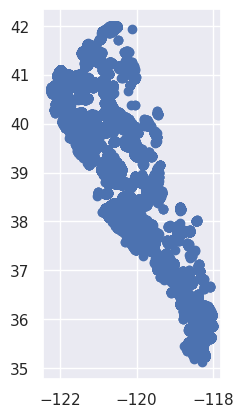

In [15]:
gedi_matched[~gedi_matched.index.isin(gedi_matched.sjoin(creek, how="inner", predicate="within").index)].plot()

<Axes: >

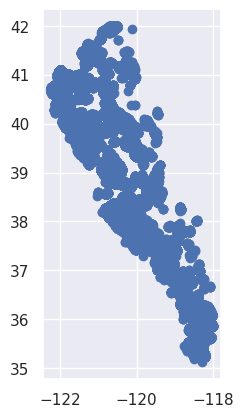

In [16]:
gedi_matched.plot()

In [33]:
gedi_matched.symmetric_difference(creek.geometry.iloc[0])

In [ ]:
for perimeter in perimeters.itertuples():
    fire = perimeters[perimeters.index == perimeter.Index]

    

## Regen analysis for 3x3 - B

In [5]:
gedi_matched = regen_analysis.process_all_fires_with_rf_control_per_burn_year(f"{DATA_PATH}/rf/burned/3x3", f"{DATA_PATH}/rf/models_ver_B")

Process fires for year 1985.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1986.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1987.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1988.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1989.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1990.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1991.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1992.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1993.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1994.
matching shots within fire
Processi

In [4]:
gedi_matched['rel_agbd'] = gedi_matched.agbd / gedi_matched.agbd_control

In [5]:
gedi_matched_trees = gedi_matched[gedi_matched.pft_class == 1]

In [19]:
print(gedi_matched_trees[(gedi_matched_trees.time_since_burn == 5) & (gedi_matched_trees.severity == 2)].mean())
print(gedi_matched_trees[(gedi_matched_trees.time_since_burn == 5) & (gedi_matched_trees.severity == 2)].std())
print(gedi_matched_trees_2[(gedi_matched_trees.time_since_burn == 5) & (gedi_matched_trees.severity == 2)].mean())

shot_number   longitude   latitude        agbd  \
2154421    48550100200078142 -120.680048  38.792635  221.652328   
2194996    48550300200078058 -120.661560  38.790566  181.701340   
2523780    48550100200078154 -120.673954  38.796560  210.159332   
2524293    48550100200078132 -120.685083  38.789400   69.569130   
2526005    48550300200078099 -120.640762  38.803937  306.494324   
...                      ...         ...        ...         ...   
27518746  194810000200062675 -120.924798  39.922261  290.192596   
27518767  194810100200058920 -120.921148  39.917263  182.097427   
27524519  194810300200058869 -120.921951  39.903272  236.528076   
27524520  194810300200058870 -120.921409  39.903595  283.914978   
27528460  194810100200058882 -120.941448  39.905074  344.128418   

          agbd_pi_lower  agbd_pi_upper    agbd_se beam_type  sensitivity  \
2154421       88.449089     414.987732  11.102393  coverage     0.968350   
2194996       63.917866     359.650848  11.108645  coverage     0.976756   
2523780       81.158669     399.397644  11.121867  coverage     0.974294   
2524293        8.168209     191.092331  11.100563  coverage     0.959238   
2526005      144.527374     528.632324  11.109563  coverage     0.992039   
...                 ...            ...        ...       ...          ...   
27518746     133.416046     507.127594  11.107244  coverage     0.954482   
27518767      64.098694     360.336487  11.122354  coverage     0.966954   
27524519      97.735558     435.674164  11.143270  coverage     0.963956   
27524520     129.082184     498.991577  11.123005  coverage     0.966781   
27528460     170.693054     577.750488  11.112468  coverage     0.951340   

          pft_class  ...  severity  burn_year burn_count time_since_burn  \
2154421           1  ...       2.0     2014.0        1.0             5.0   
2194996           1  ...       2.0     2014.0        1.0             5.0   
2523780           1  ...       2.0     2014.0        1.0             5.0   
2524293           1  ...       2.0     2014.0        1.0             5.0   
2526005           1  ...       2.0     2014.0        1.0             5.0   
...             ...  ...       ...        ...        ...             ...   
27518746          1  ...       2.0     2017.0        1.0             5.0   
27518767          1  ...       2.0     2017.0        1.0             5.0   
27524519          1  ...       2.0     2017.0        1.0             5.0   
27524520          1  ...       2.0     2017.0        1.0             5.0   
27528460          1  ...       2.0     2017.0        1.0             5.0   

            elevation      slope      aspect  soil  agbd_control  rel_agbd  
2154421    682.111111  37.888889  278.222222  19.0    240.051035  0.923355  
2194996    660.555556  22.555556  113.111111   5.0    172.133982  1.055581  
2523780    722.333333  35.333333  320.333333  19.0    243.935180  0.861538  
2524293    648.222222  32.777778  143.666667  19.0    172.392078  0.403552  
2526005    700.000000  32.000000  316.333333   5.0    334.465313  0.916371  
...               ...        ...         ...   ...           ...       ...  
27518746  1289.222222   4.555556  139.222222   0.0    178.409858  1.626550  
27518767  1220.000000  21.000000  310.000000   0.0    440.888725  0.413024  
27524519  1370.666667  14.000000  331.666667   0.0    371.195082  0.637207  
27524520  1376.666667  17.000000  300.666667   0.0    283.205555  1.002505  
27528460  1548.666667  22.000000  107.333333   0.0    325.648801  1.056747  

[2806 rows x 24 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


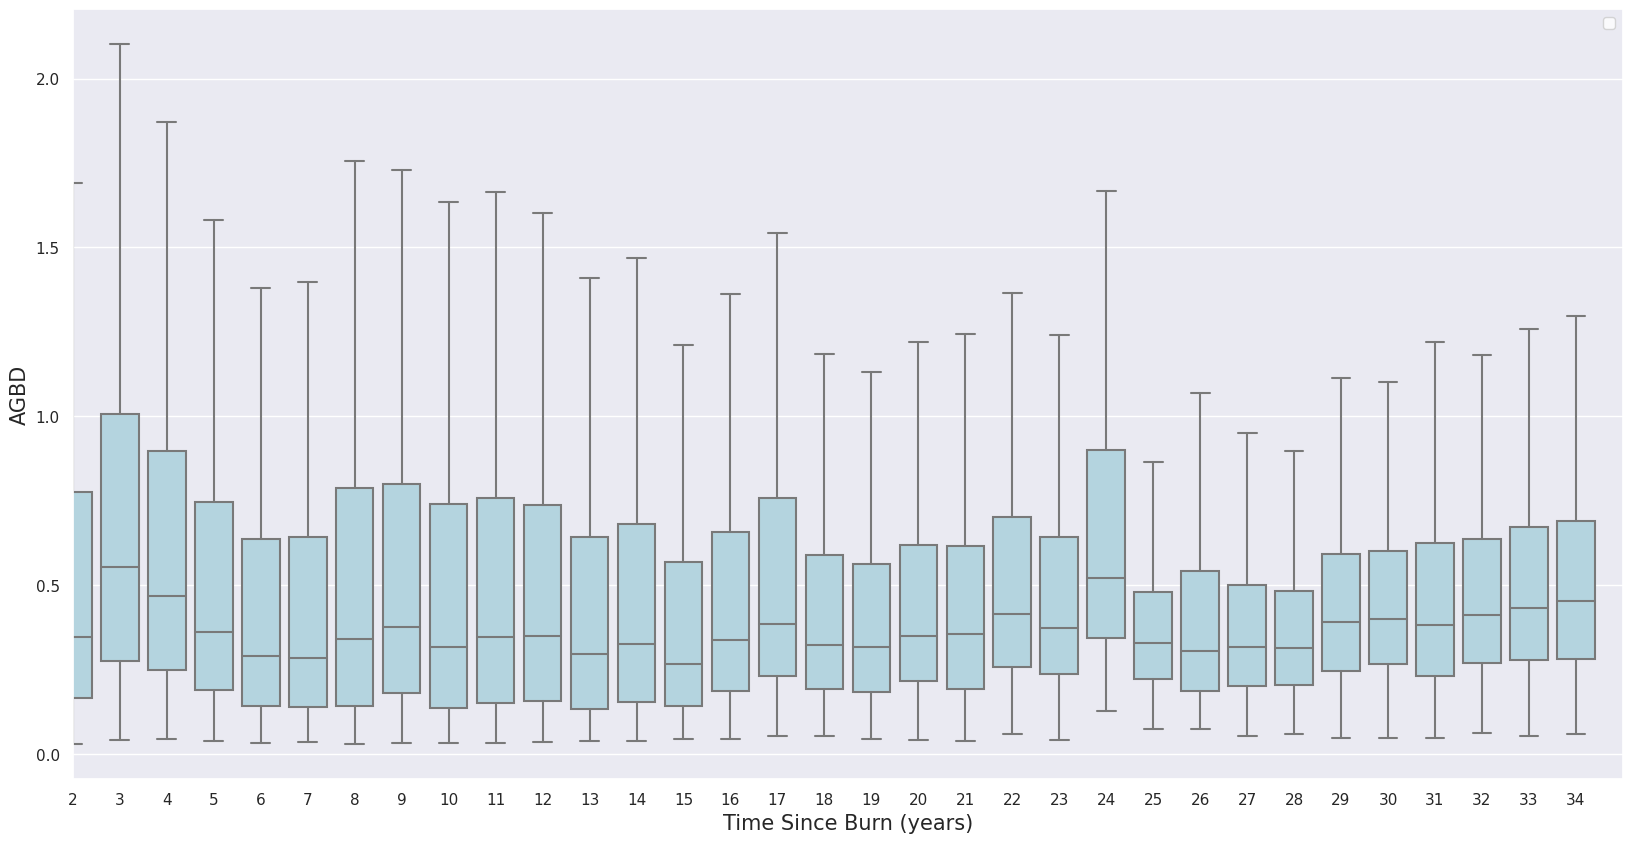

In [21]:
import numpy as np
plt.figure(1, (20,10))
ax = sns.boxplot(x="time_since_burn", y="rel_agbd", data=gedi_matched_trees, color='lightblue', showfliers=False, order=np.arange(35))
ax.set_ylabel("AGBD", fontsize=15)
ax.set_xlabel("Time Since Burn (years)", fontsize=15)
ax.set_xlim([2,35])
xs = np.arange(2, 35)

ax.legend(facecolor='white')
#ax.set_ylim([0, ])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


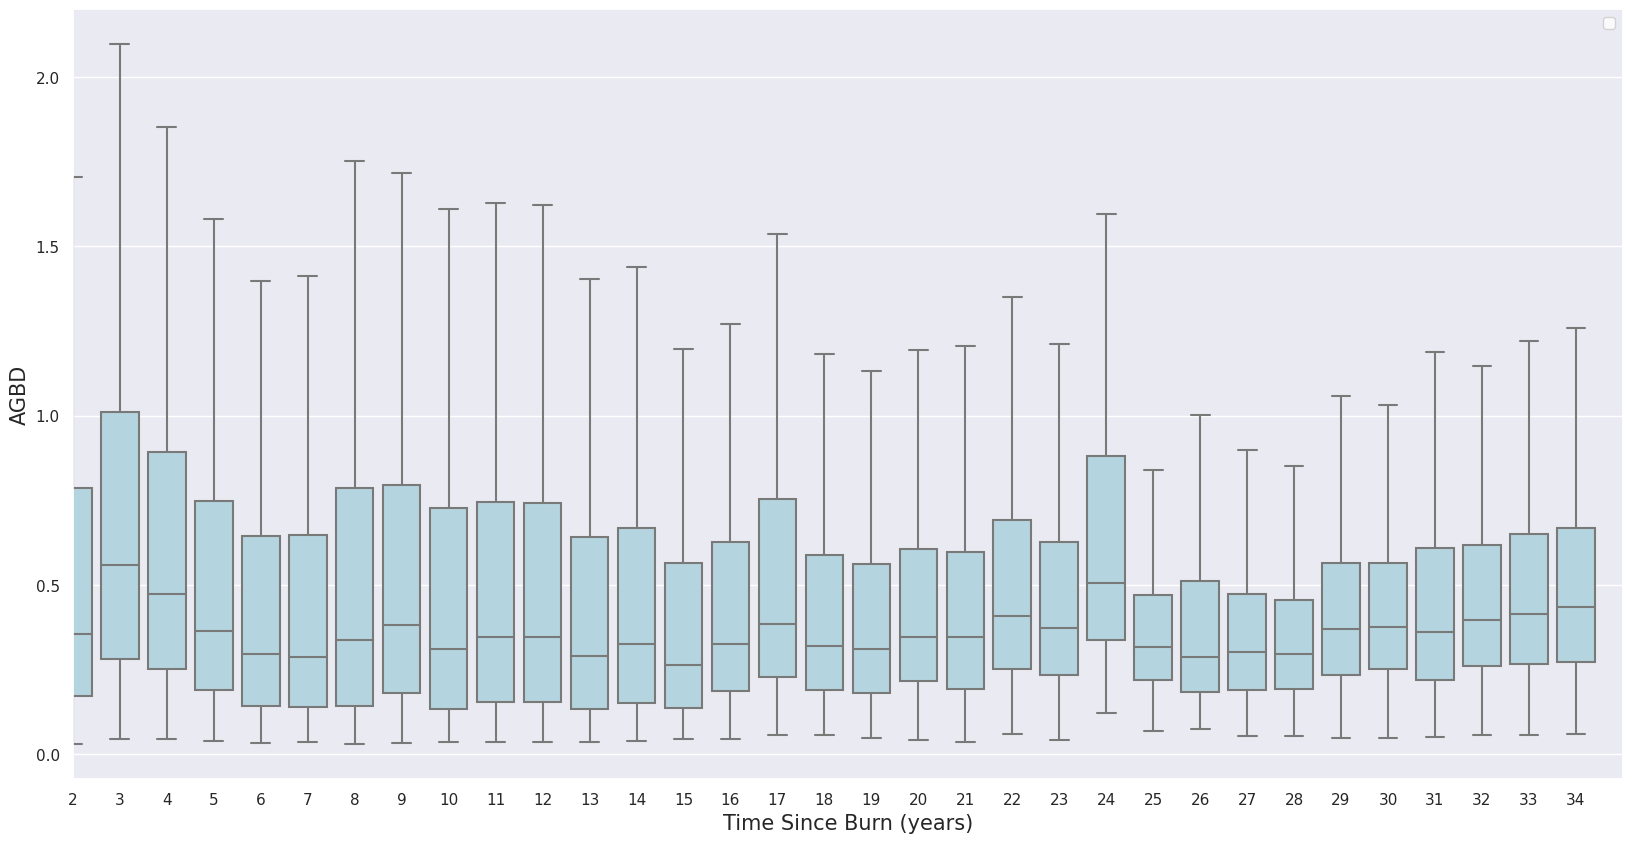

In [22]:
import numpy as np
plt.figure(1, (20,10))
ax = sns.boxplot(x="time_since_burn", y="rel_agbd", data=gedi_matched_trees_2, color='lightblue', showfliers=False, order=np.arange(35))
ax.set_ylabel("AGBD", fontsize=15)
ax.set_xlabel("Time Since Burn (years)", fontsize=15)
ax.set_xlim([2,35])
xs = np.arange(2, 35)

ax.legend(facecolor='white')
#ax.set_ylim([0, ])

93248


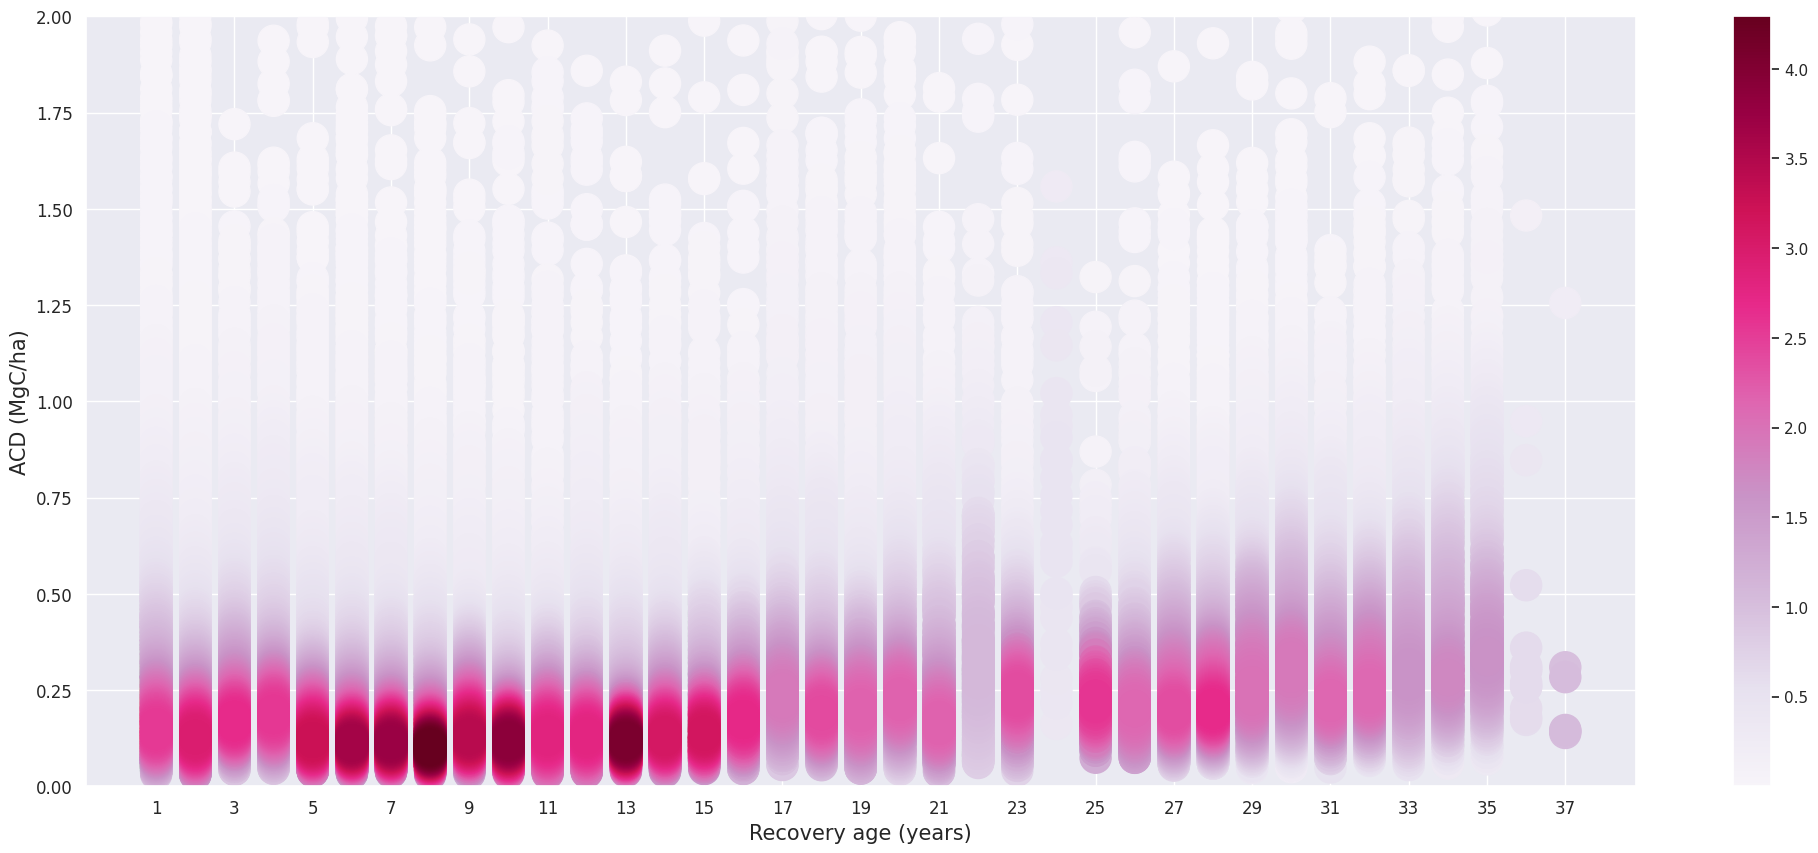

93248


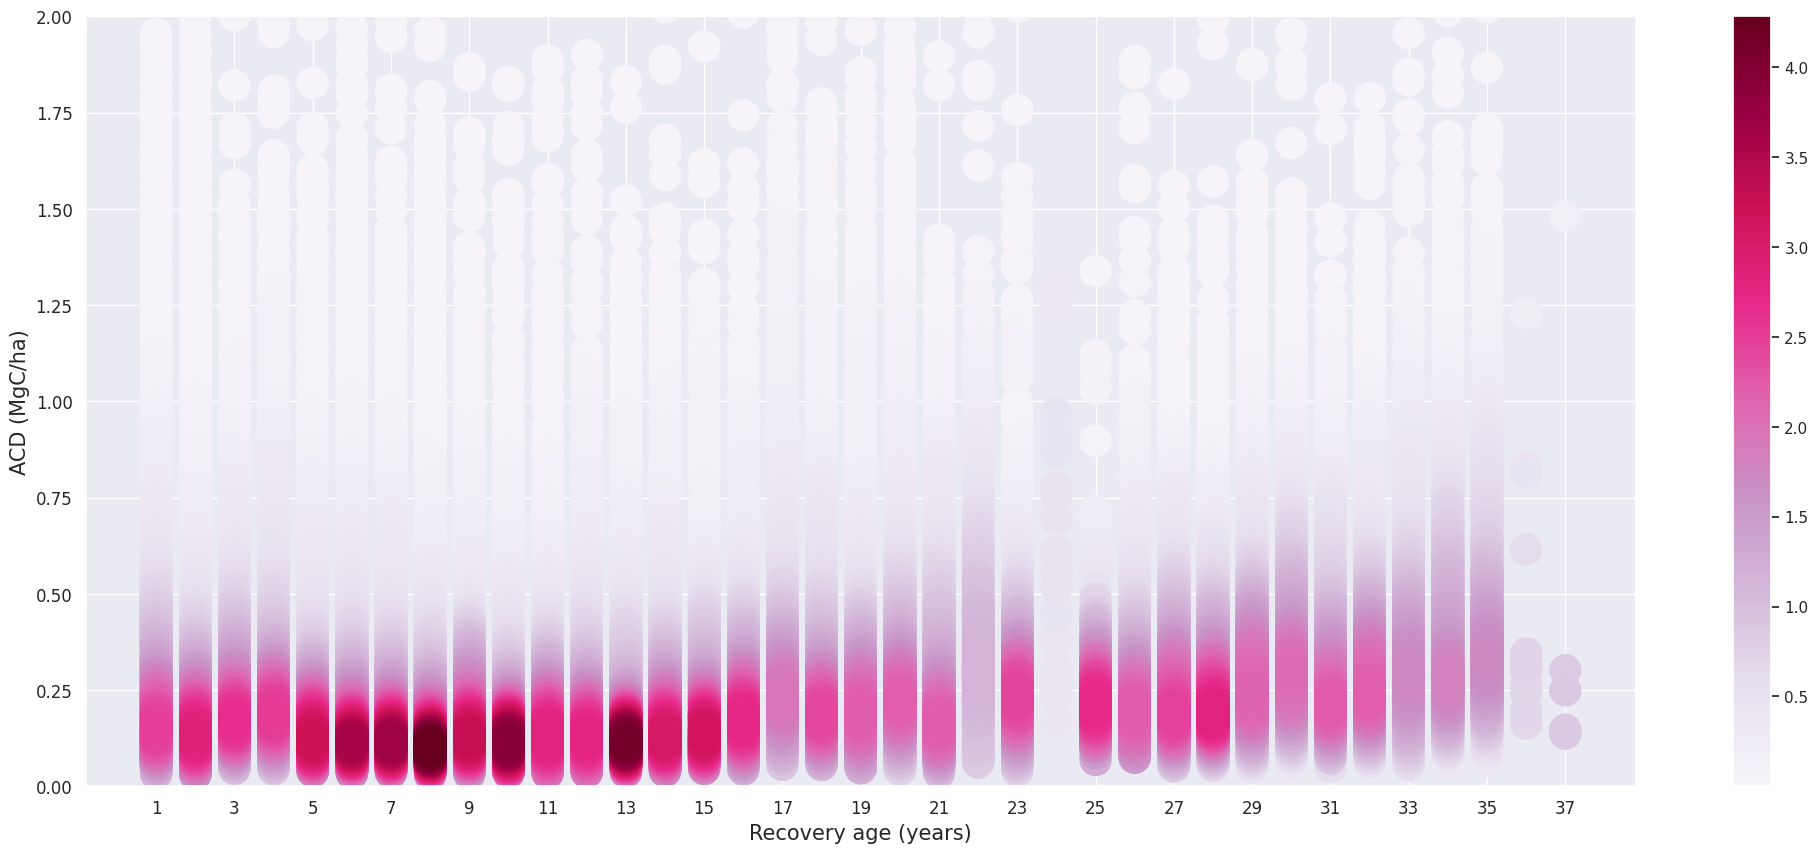

In [24]:
plot_pdf(gedi_matched_trees[gedi_matched_trees.severity == 4],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))
plot_pdf(gedi_matched_trees_2[gedi_matched_trees_2.severity == 4],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))

50521


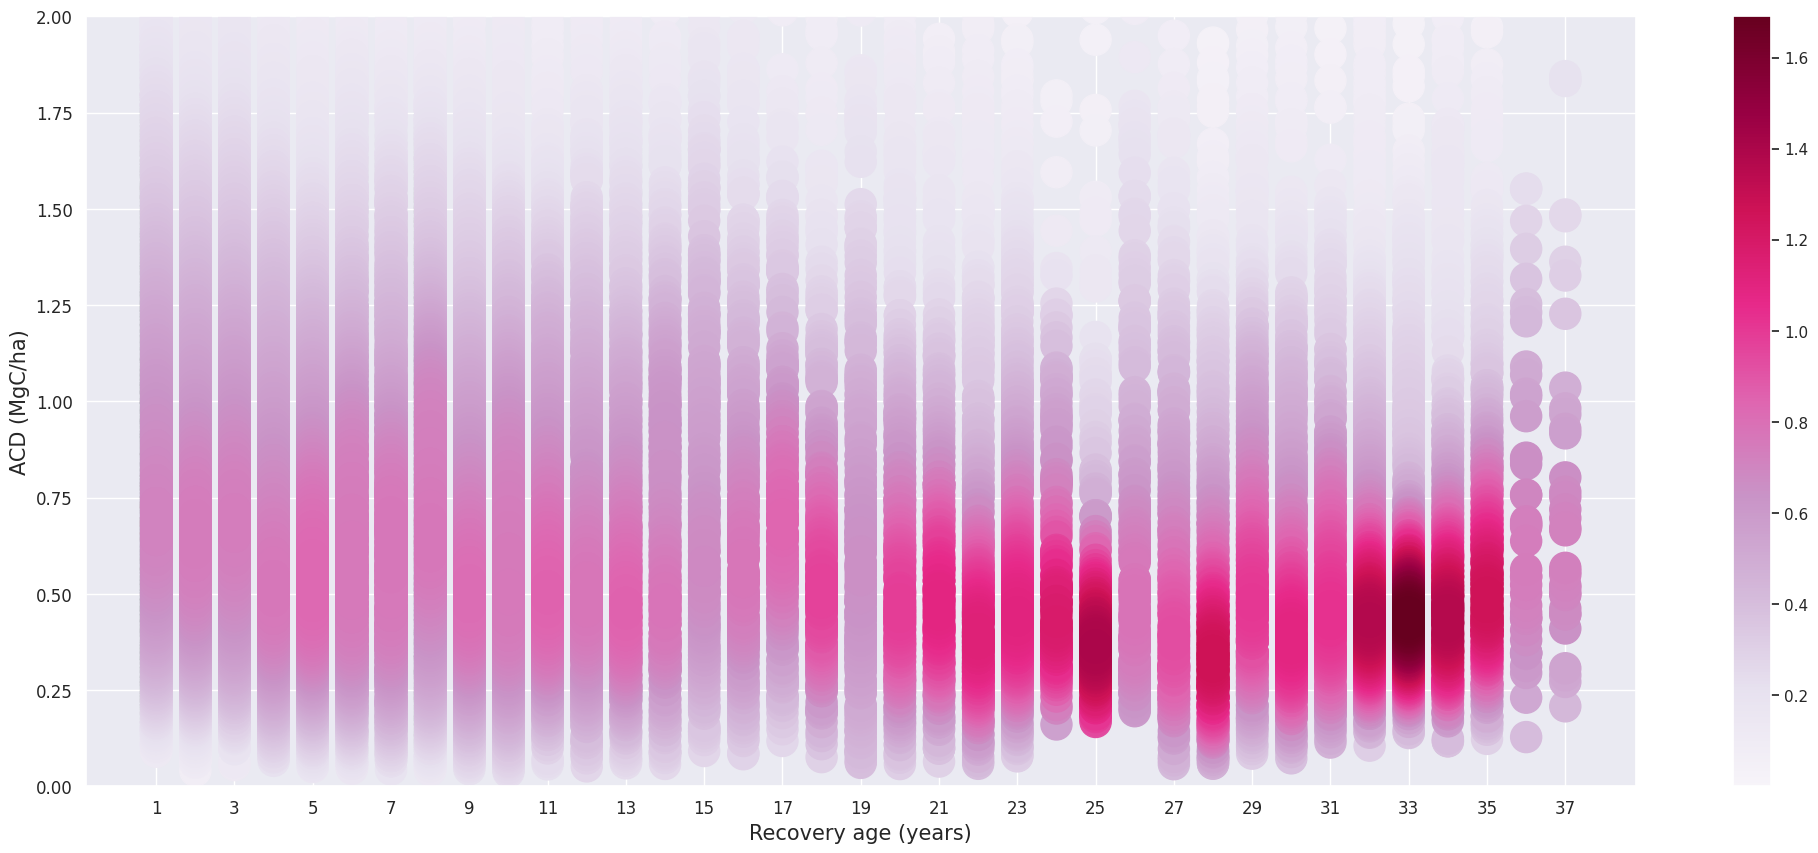

In [17]:
plot_pdf(gedi_matched_trees_2[gedi_matched_trees_2.severity == 2],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))

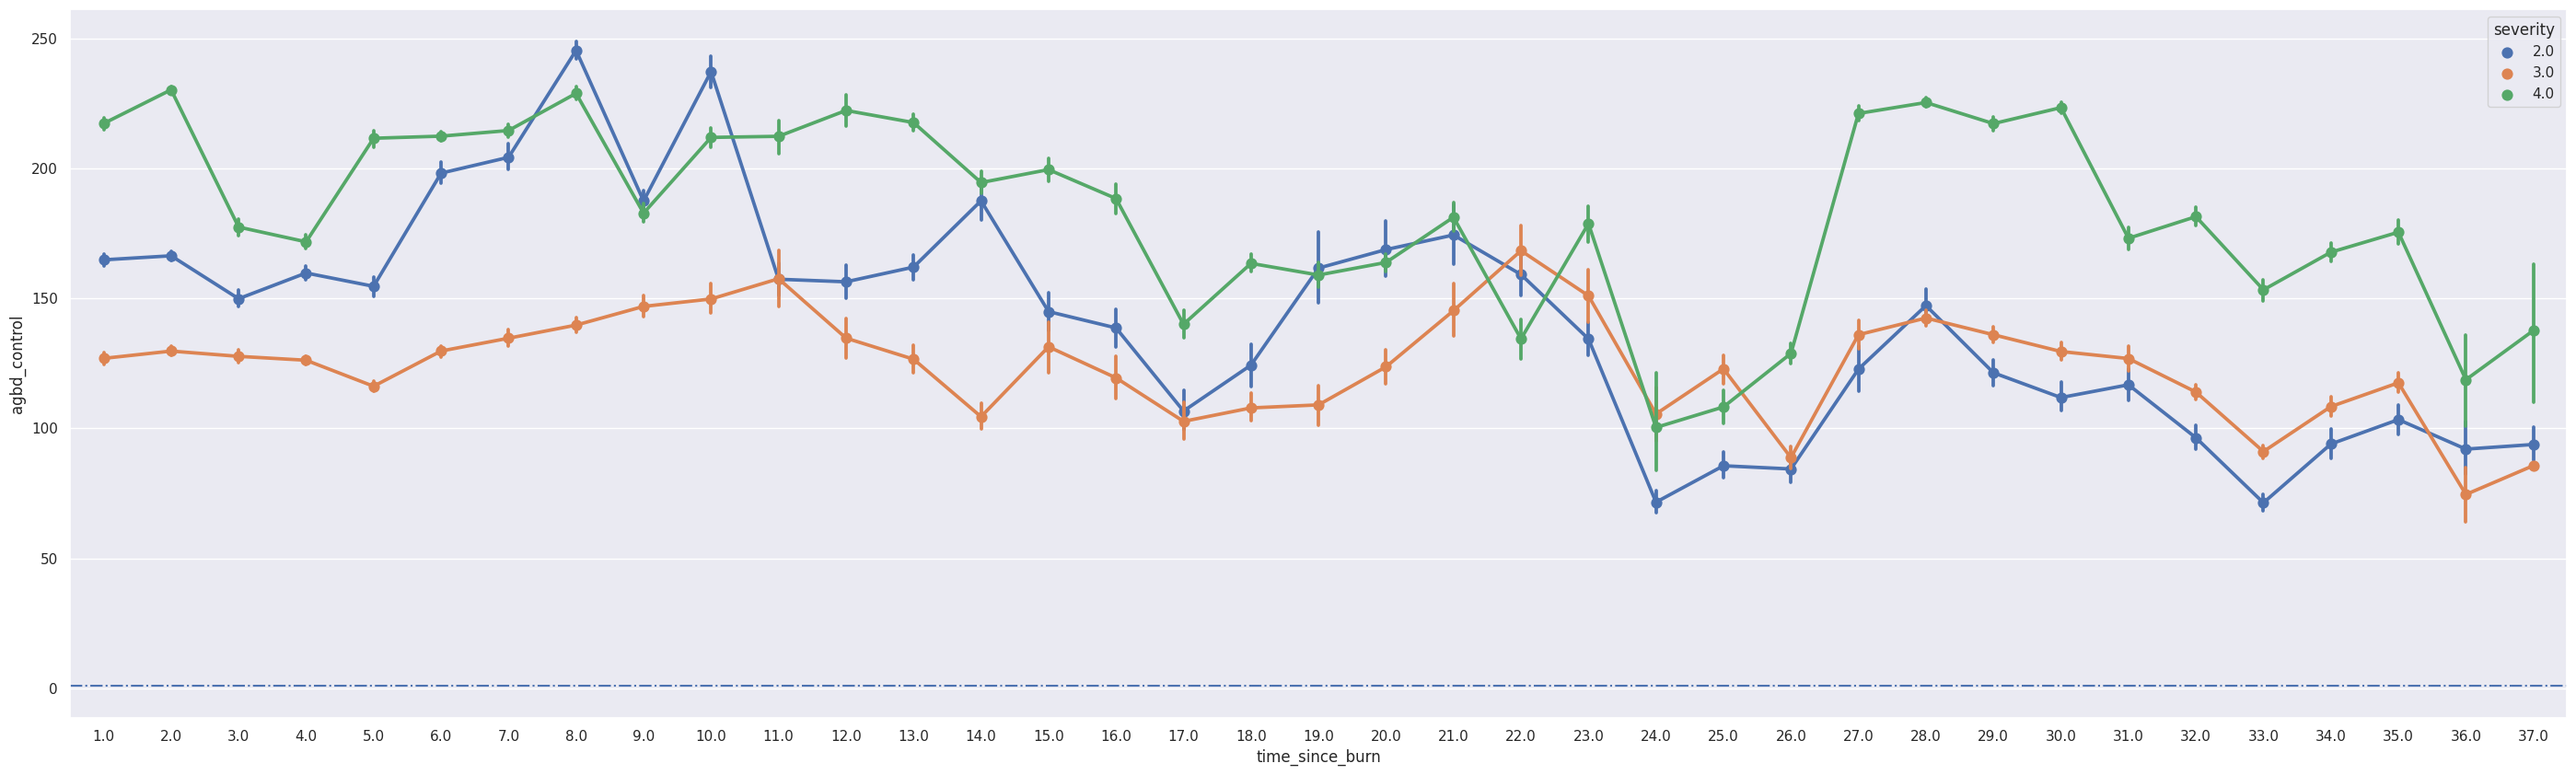

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_matched_trees, x='time_since_burn', y='agbd_control', hue='severity')
ax.axhline(y=1, linestyle="-.")

## Regen analysis for 3x3 gedi shots

In [10]:
gedi_matched_2 = regen_analysis.process_all_fires_with_rf_control_per_burn_year(f"{DATA_PATH}/rf/burned/3x3")

Process fires for year 1985.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1986.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1987.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1988.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1989.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1990.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1991.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1992.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1993.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1994.
matching shots within fire
Processi

In [11]:
gedi_matched_2['rel_agbd'] = gedi_matched_2.agbd / gedi_matched_2.agbd_control

In [12]:
gedi_matched_trees_2 = gedi_matched_2[gedi_matched_2.pft_class == 1]

In [13]:
gedi_matched_trees_2

shot_number   longitude   latitude        agbd  \
70255     191910500200119943 -120.740033  38.155407  123.460587   
72312      81650600200449990 -120.754568  38.096837   16.602076   
72313      81650600200449991 -120.754079  38.097166   18.214243   
73150     225021100200119926 -120.738474  38.154606   83.151505   
2260492   204310800300304361 -120.757143  38.096809  101.912163   
...                      ...         ...        ...         ...   
27618963  225630800200085757 -119.553059  38.564323  122.198563   
27618964  225630800200085760 -119.551527  38.565317   28.583668   
27618967  225630800200085764 -119.549511  38.566621   20.807606   
27618975  225631100200080331 -119.554363  38.556271  131.316925   
27624050  156220200200085334 -119.406297  38.528133   31.825970   

          agbd_pi_lower  agbd_pi_upper    agbd_se beam_type  sensitivity  \
70255         31.679453     275.364624  11.100678      full     0.988443   
72312      -9999.000000      91.402557  11.113122      full     0.958655   
72313      -9999.000000      95.125694  11.111183      full     0.961252   
73150         13.214792     213.226410  11.103502      full     0.984161   
2260492       21.273869     242.672516  11.100528      full     0.988056   
...                 ...            ...        ...       ...          ...   
27618963      31.039167     273.485962  11.101624      full     0.988854   
27618964   -9999.000000     117.301216  11.106215      full     0.983052   
27618967   -9999.000000     100.928558  11.108585      full     0.968726   
27618975      35.723694     287.024231  11.099050      full     0.994654   
27624050       0.024733     123.779739  11.106153  coverage     0.951131   

          pft_class  ...  severity  burn_year burn_count time_since_burn  \
70255             1  ...       2.0     1985.0        1.0            37.0   
72312             1  ...       4.0     1985.0        1.0            35.0   
72313             1  ...       4.0     1985.0        1.0            35.0   
73150             1  ...       2.0     1985.0        1.0            37.0   
2260492           1  ...       4.0     1985.0        1.0            37.0   
...             ...  ...       ...        ...        ...             ...   
27618963          1  ...       2.0     2020.0        1.0             2.0   
27618964          1  ...       2.0     2020.0        1.0             2.0   
27618967          1  ...       3.0     2020.0        1.0             2.0   
27618975          1  ...       2.0     2020.0        1.0             2.0   
27624050          1  ...       4.0     2020.0        1.0             1.0   

            elevation      slope      aspect  soil  agbd_control  rel_agbd  
70255      539.000000  20.000000   48.666667   0.0    100.605161  1.227179  
72312      345.000000   8.000000  185.000000   0.0     62.928008  0.263826  
72313      354.222222  10.222222  197.222222   0.0     70.196329  0.259476  
73150      512.333333  25.333333   51.666667   0.0    103.647873  0.802250  
2260492    337.000000  15.000000  229.333333   0.0     68.853135  1.480138  
...               ...        ...         ...   ...           ...       ...  
27618963  2090.000000  30.666667  289.666667  19.0    105.198435  1.161601  
27618964  2126.000000  25.333333  301.333333  19.0     81.820967  0.349344  
27618967  2134.333333  11.333333    9.666667  19.0     74.188719  0.280469  
27618975  2144.333333  29.666667  278.333333  19.0    109.821963  1.195726  
27624050  2419.333333  16.333333  228.000000  19.0     52.403028  0.607331  

[176376 rows x 24 columns]

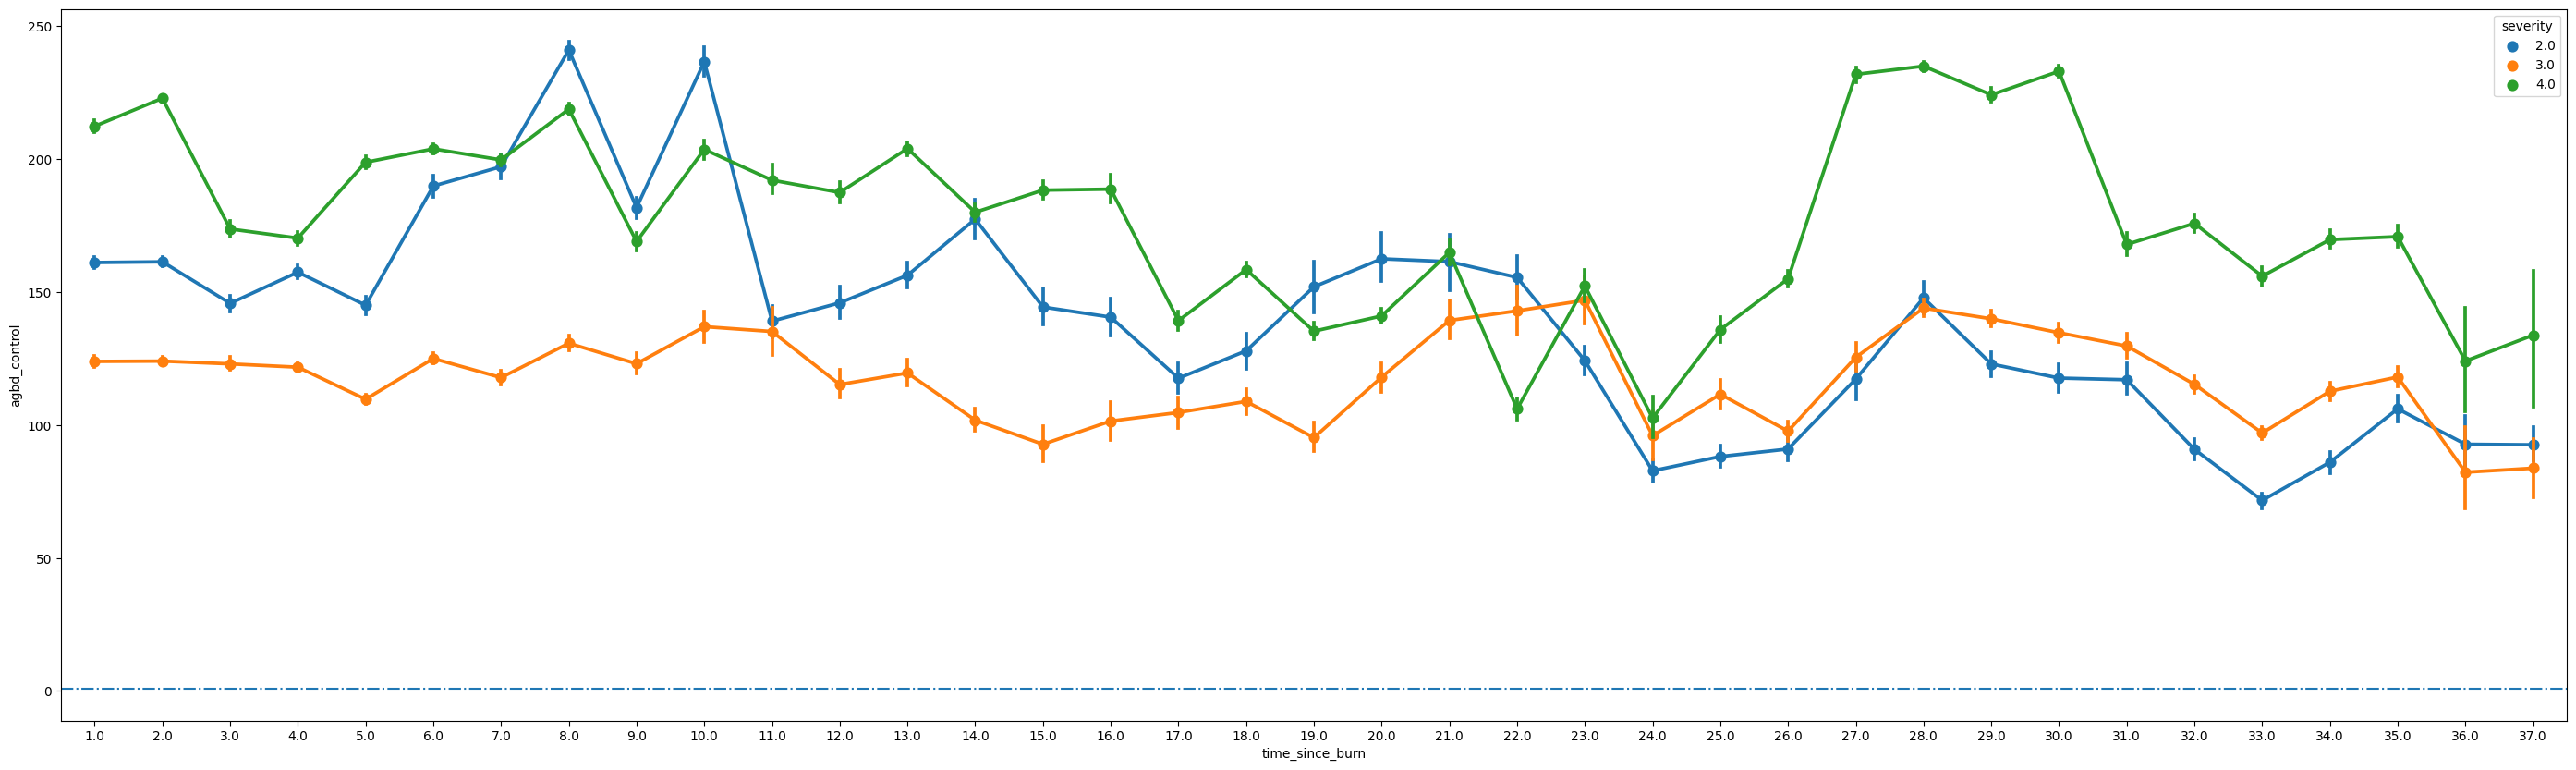

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_matched, x='time_since_burn', y='agbd_control', hue='severity')
ax.axhline(y=1, linestyle="-.")

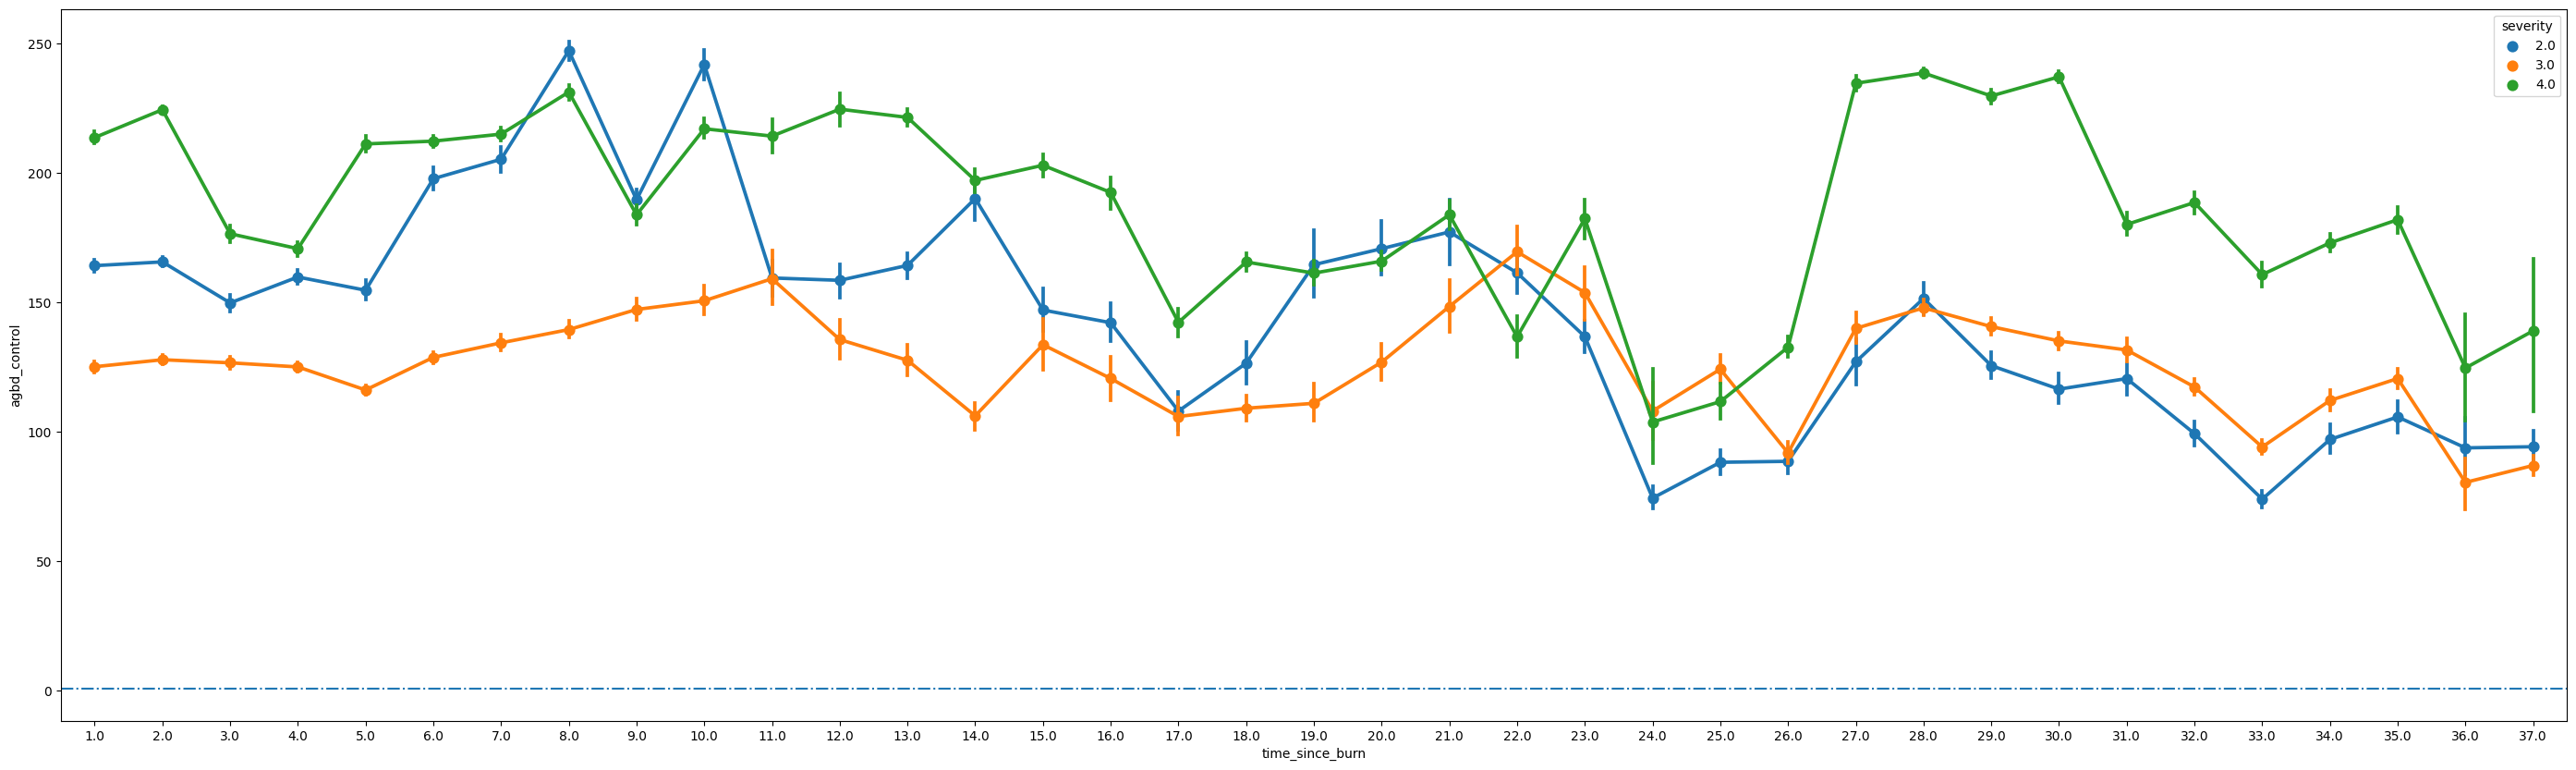

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_matched_trees, x='time_since_burn', y='agbd_control', hue='severity')
ax.axhline(y=1, linestyle="-.")

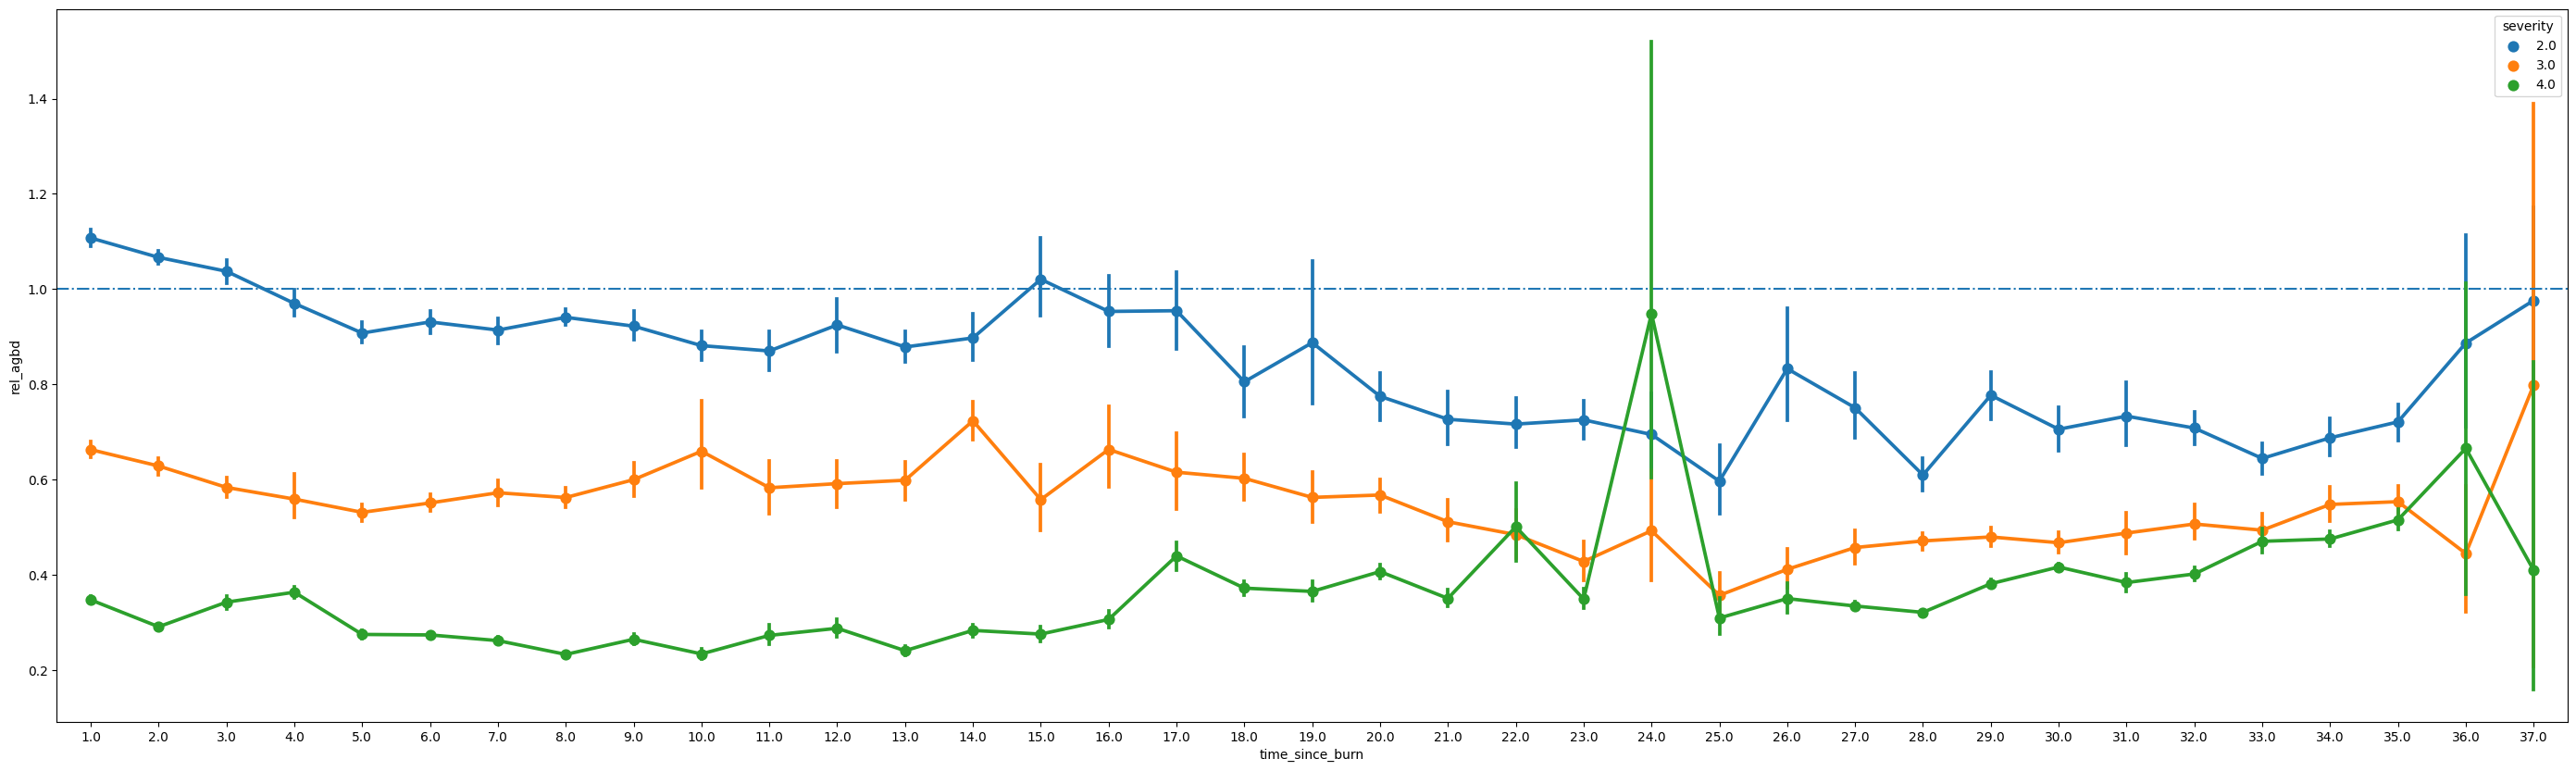

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_matched_trees, x='time_since_burn', y='rel_agbd', hue='severity')
ax.axhline(y=1, linestyle="-.")

In [152]:
res_filt_trees = res_filt[res_filt.pft_class==1]

(0.0, 1.2)

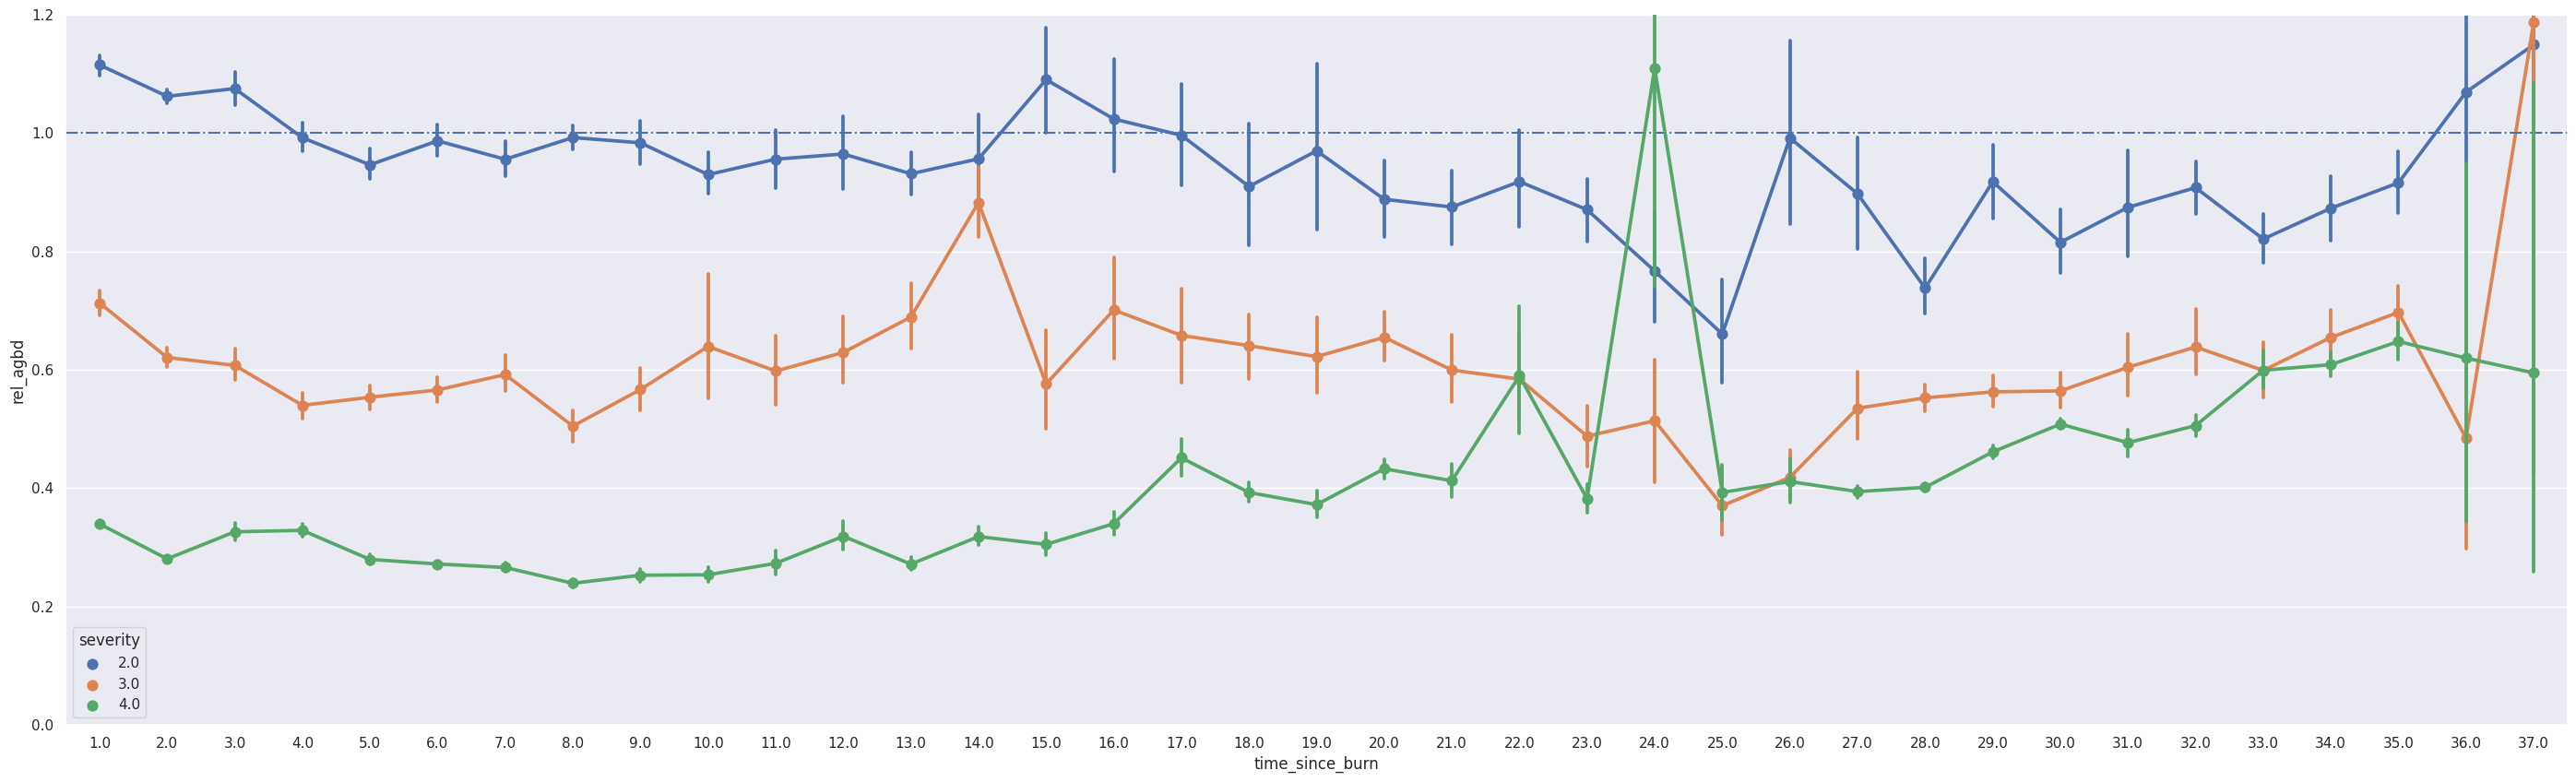

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(res_filt_trees, x='time_since_burn', y='rel_agbd', hue='severity')
ax.axhline(y=1, linestyle="-.")
ax.set_ylim((0, 1.2))

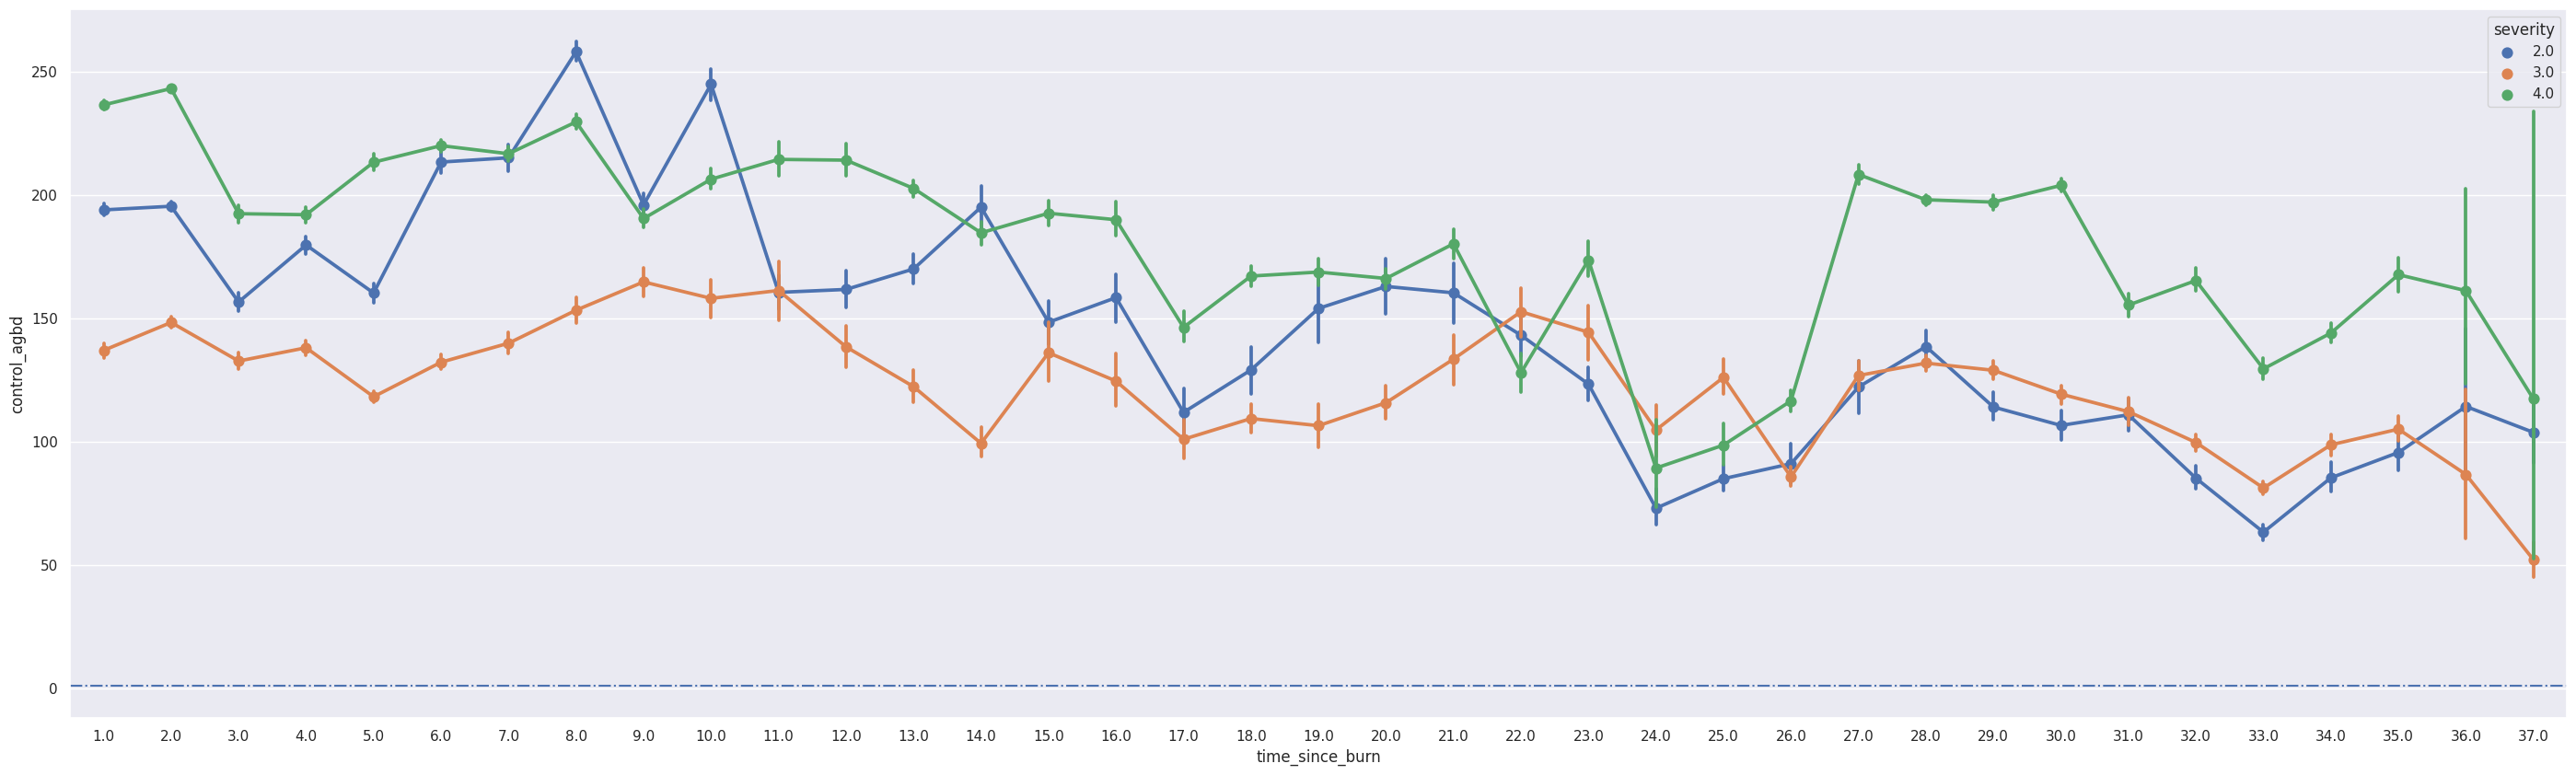

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(res_filt_trees, x='time_since_burn', y='control_agbd', hue='severity')
ax.axhline(y=1, linestyle="-.")

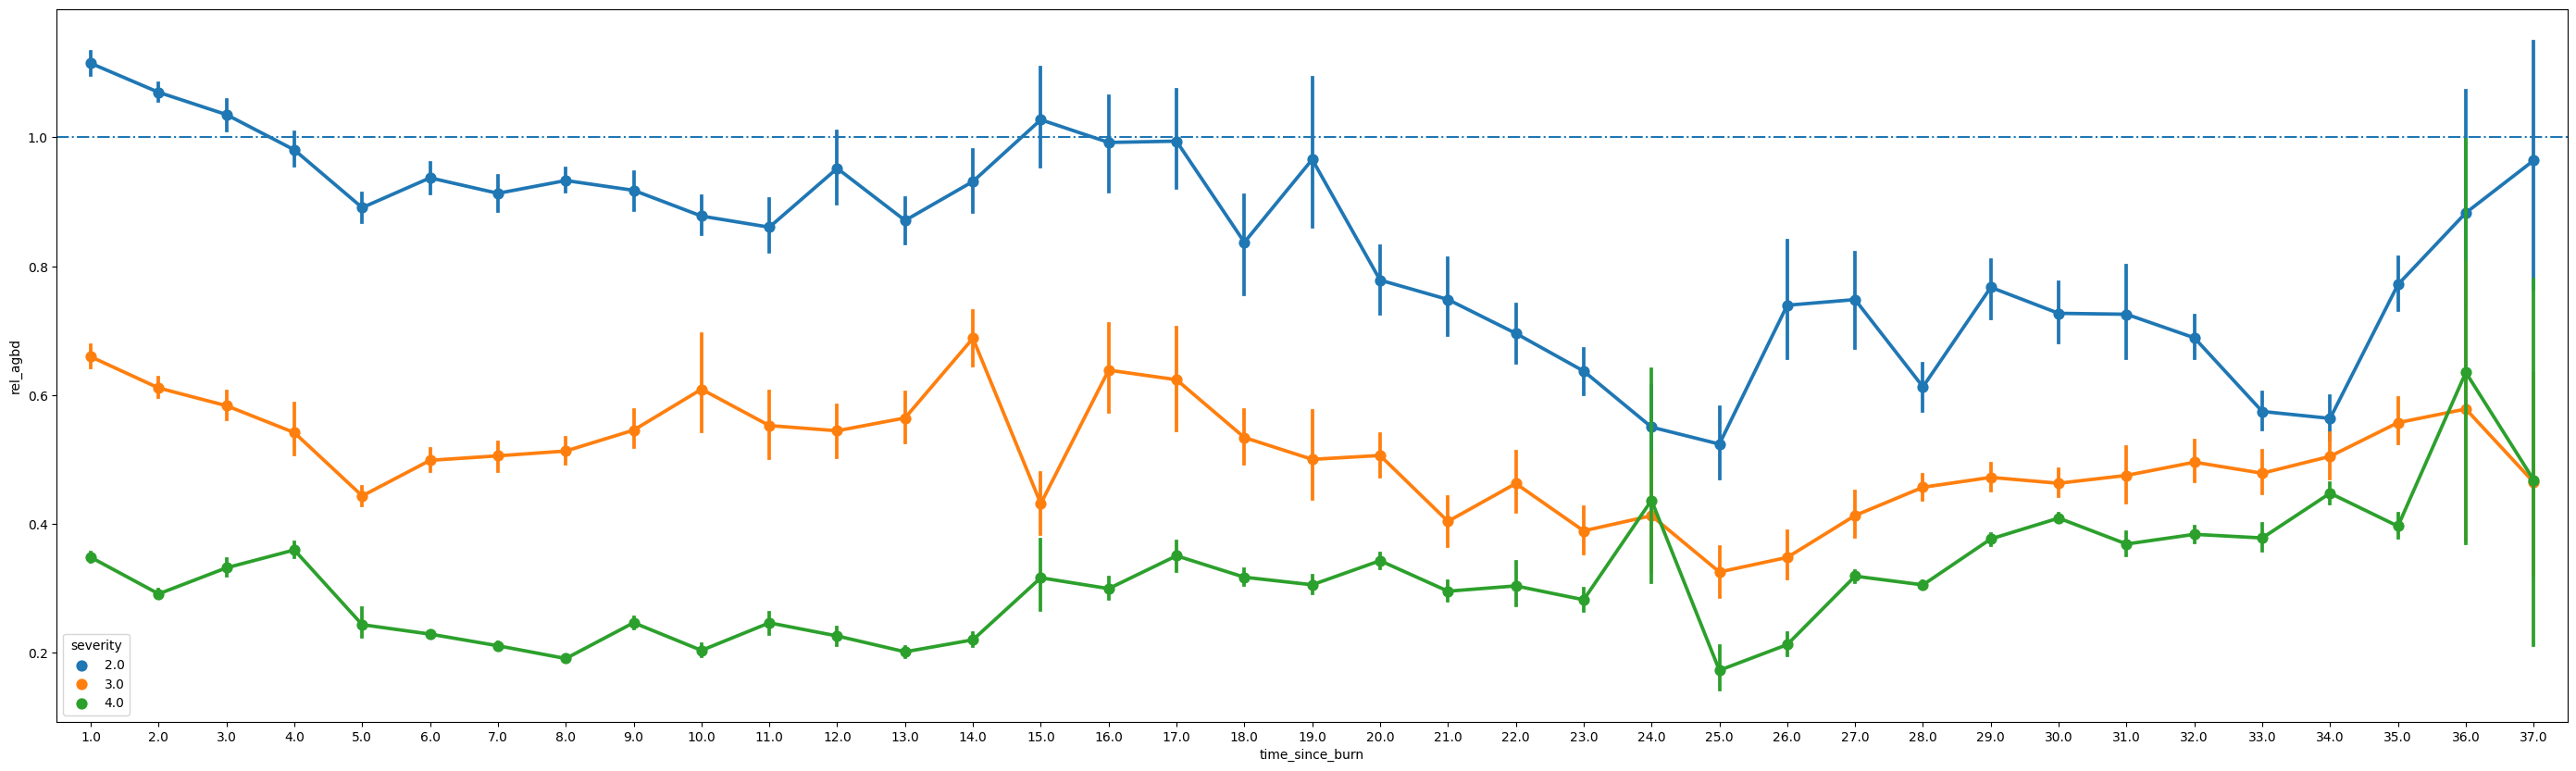

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_matched, x='time_since_burn', y='rel_agbd', hue='severity')
ax.axhline(y=1, linestyle="-.")

## Regen analysis for 2x2 gedi shots

In [6]:
gedi_matched_2 = regen_analysis.process_all_fires_with_rf_control_per_burn_year(f"{DATA_PATH}/rf/burned/2x2")

Process fires for year 1985.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1986.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1987.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1988.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1989.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1990.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1991.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1992.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1993.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1994.
matching shots within fire
Processi

In [11]:
gedi_matched_2['rel_agbd'] = gedi_matched_2.agbd / gedi_matched_2.agbd_control

In [16]:
gedi_matched_2_trees = gedi_matched_2[gedi_matched_2.pft_class == 1]

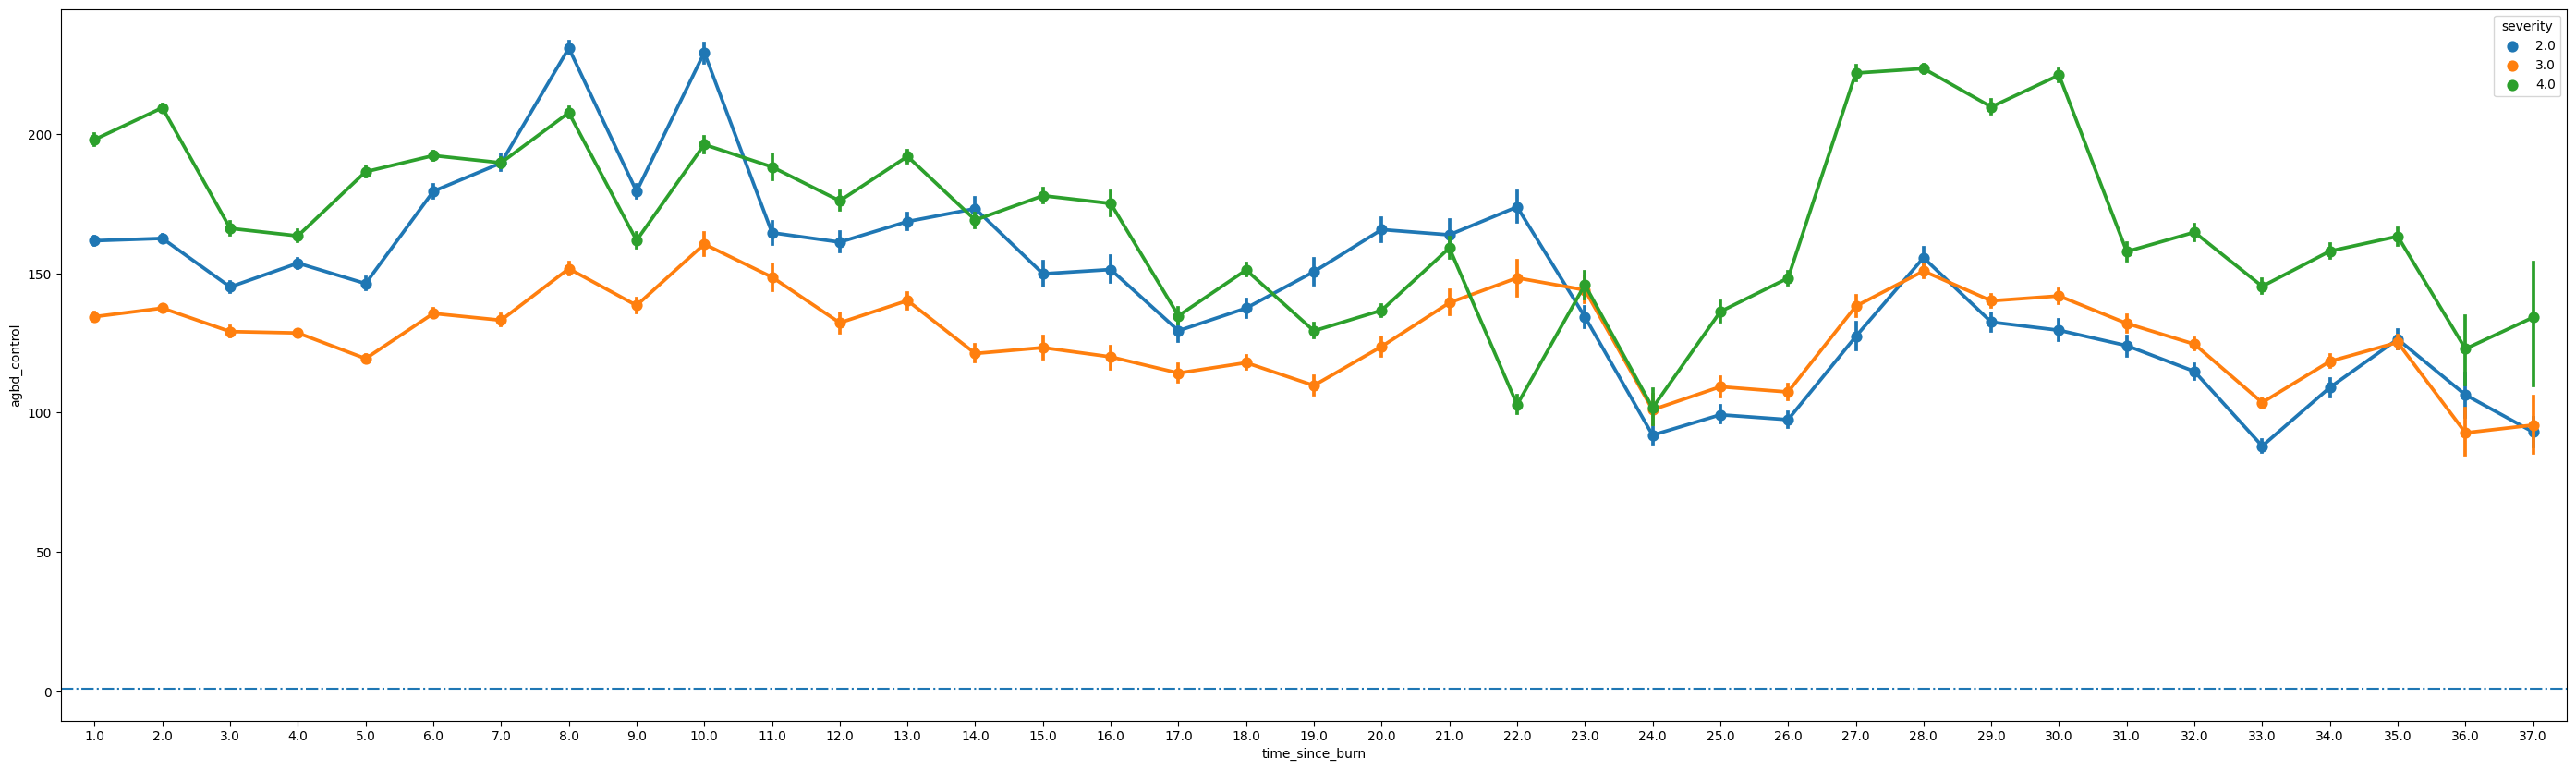

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_matched_2, x='time_since_burn', y='agbd_control', hue='severity')
ax.axhline(y=1, linestyle="-.")

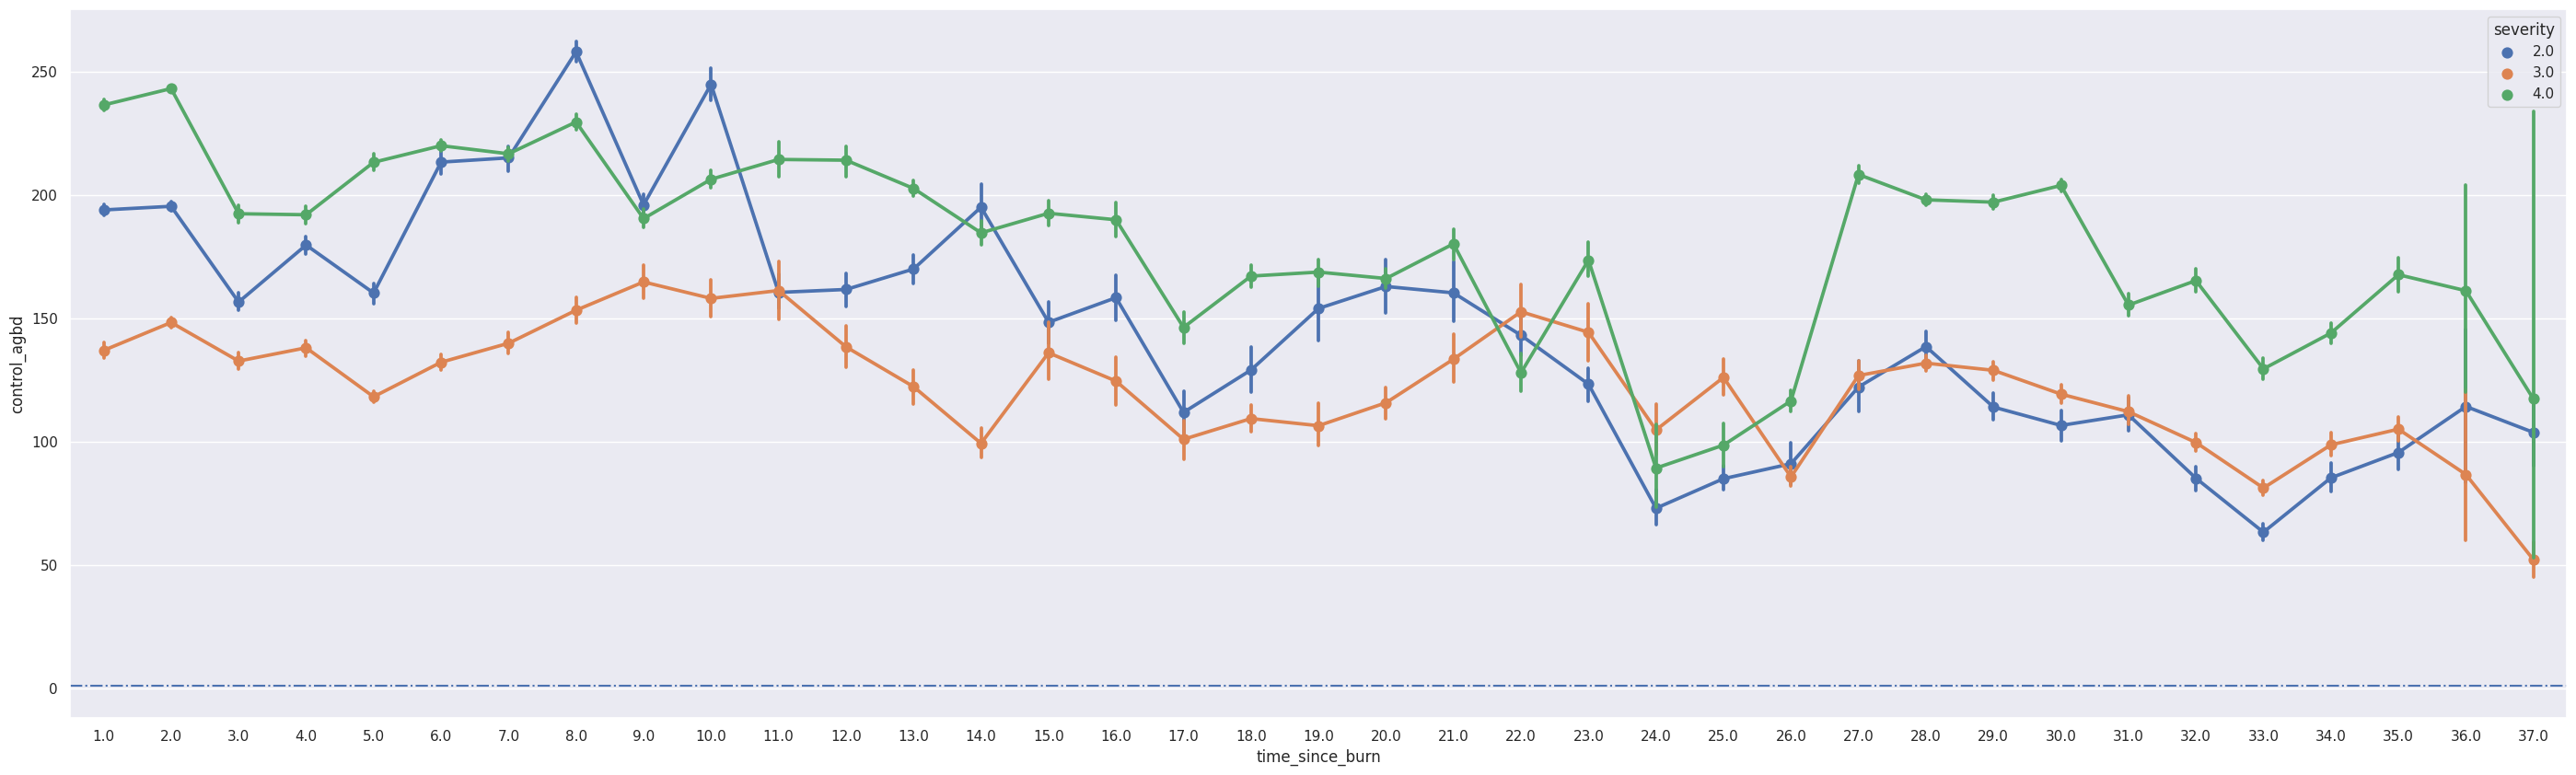

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(res_filt_trees, x='time_since_burn', y='control_agbd', hue='severity')
ax.axhline(y=1, linestyle="-.")

106695


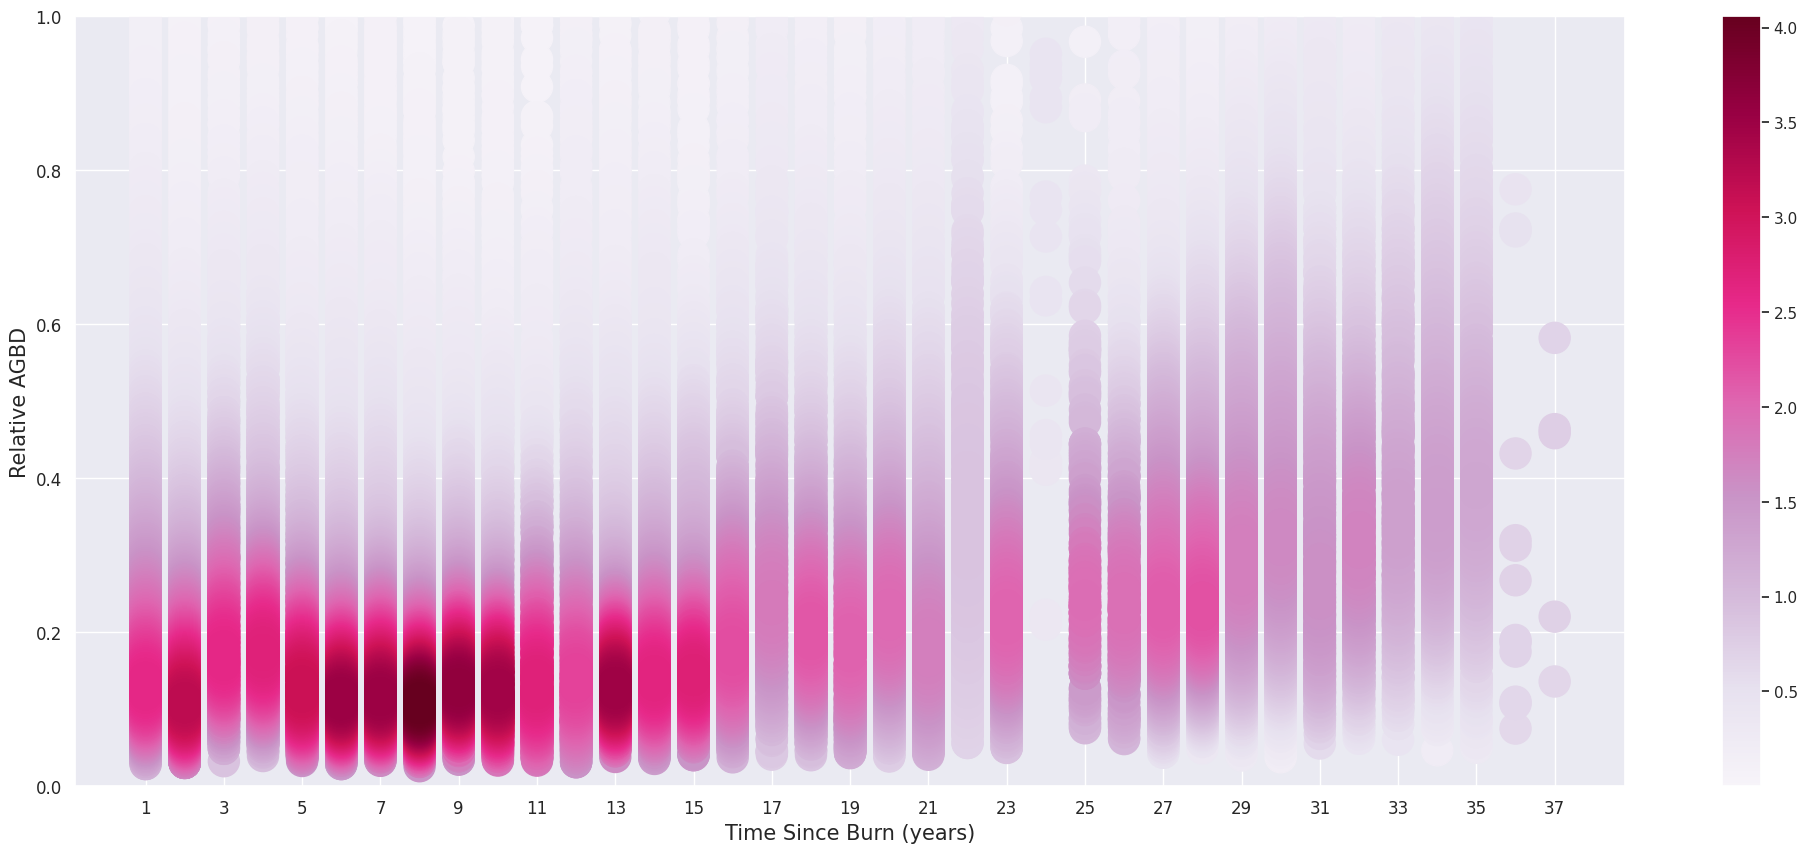

In [160]:
plot_pdf(res_filt_trees[res_filt_trees.severity == 4],
         'time_since_burn',
         'rel_agbd',
         "Time Since Burn (years)",
         "Relative AGBD",
         (0, 1))

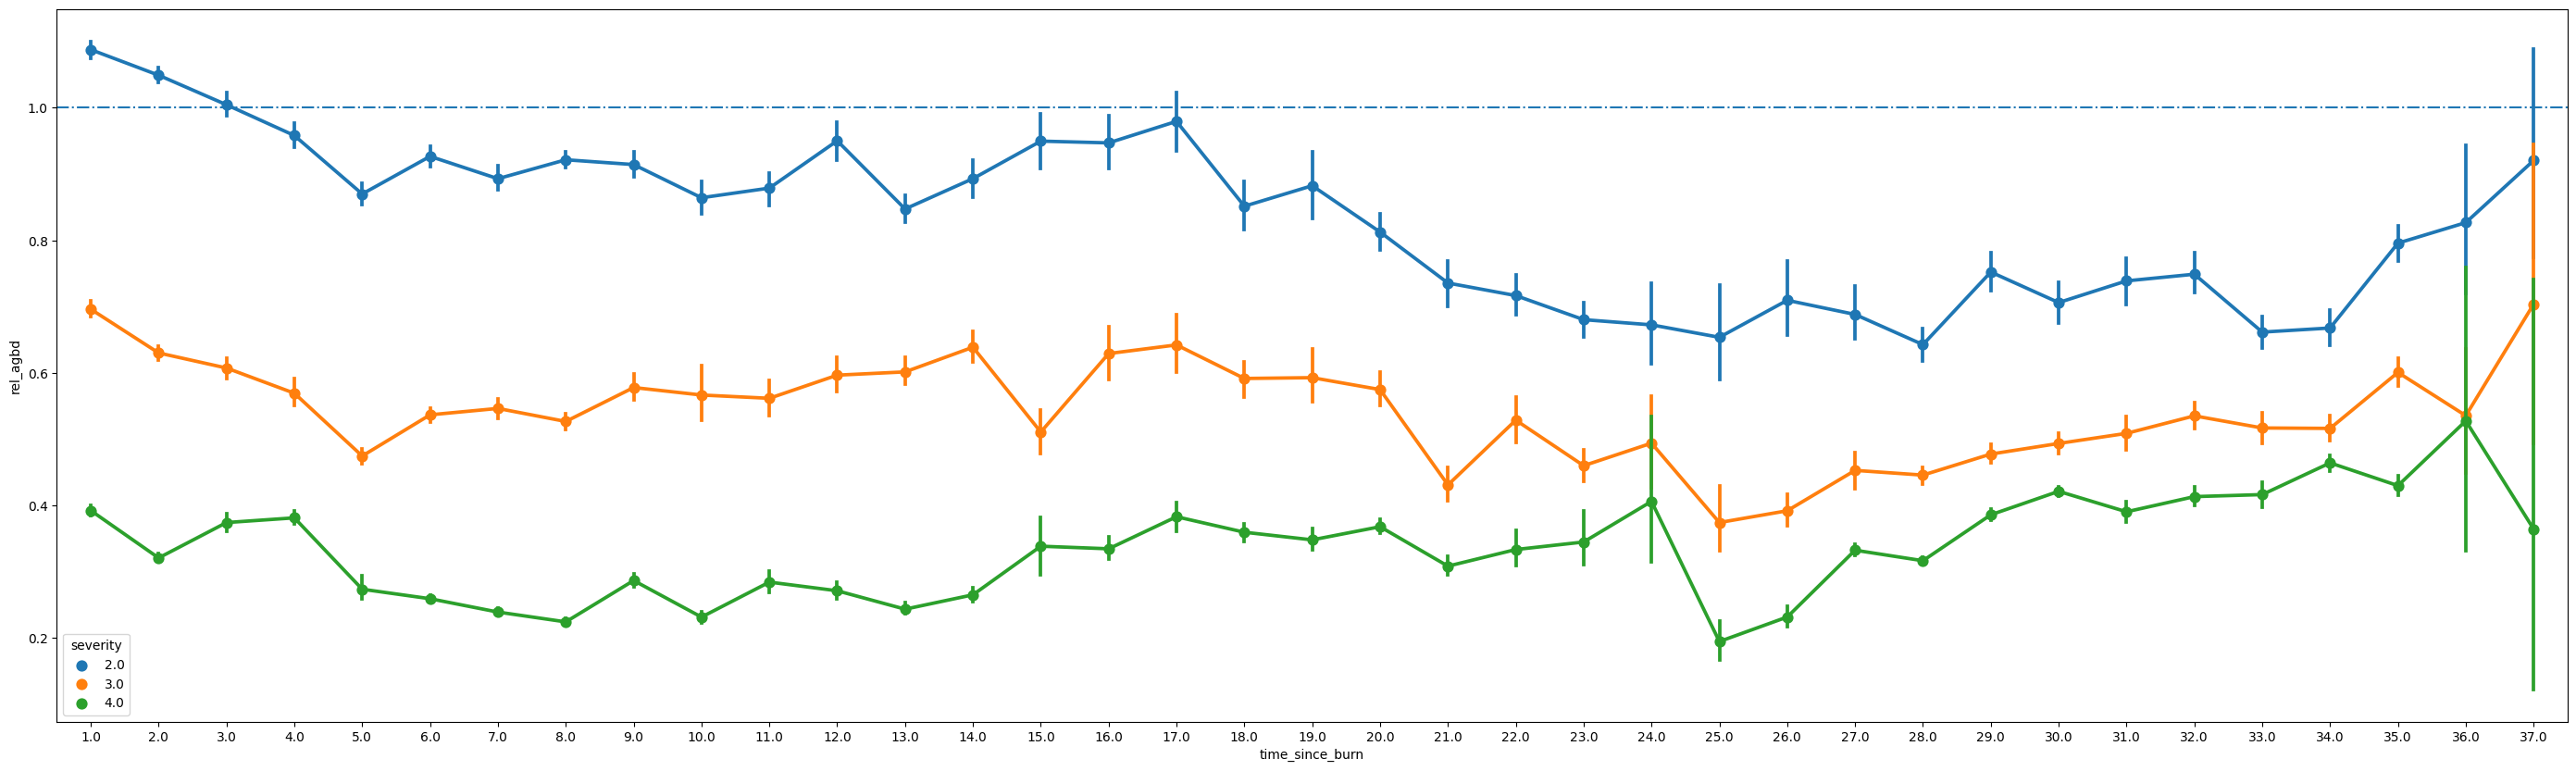

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_matched_2, x='time_since_burn', y='rel_agbd', hue='severity')
ax.axhline(y=1, linestyle="-.")

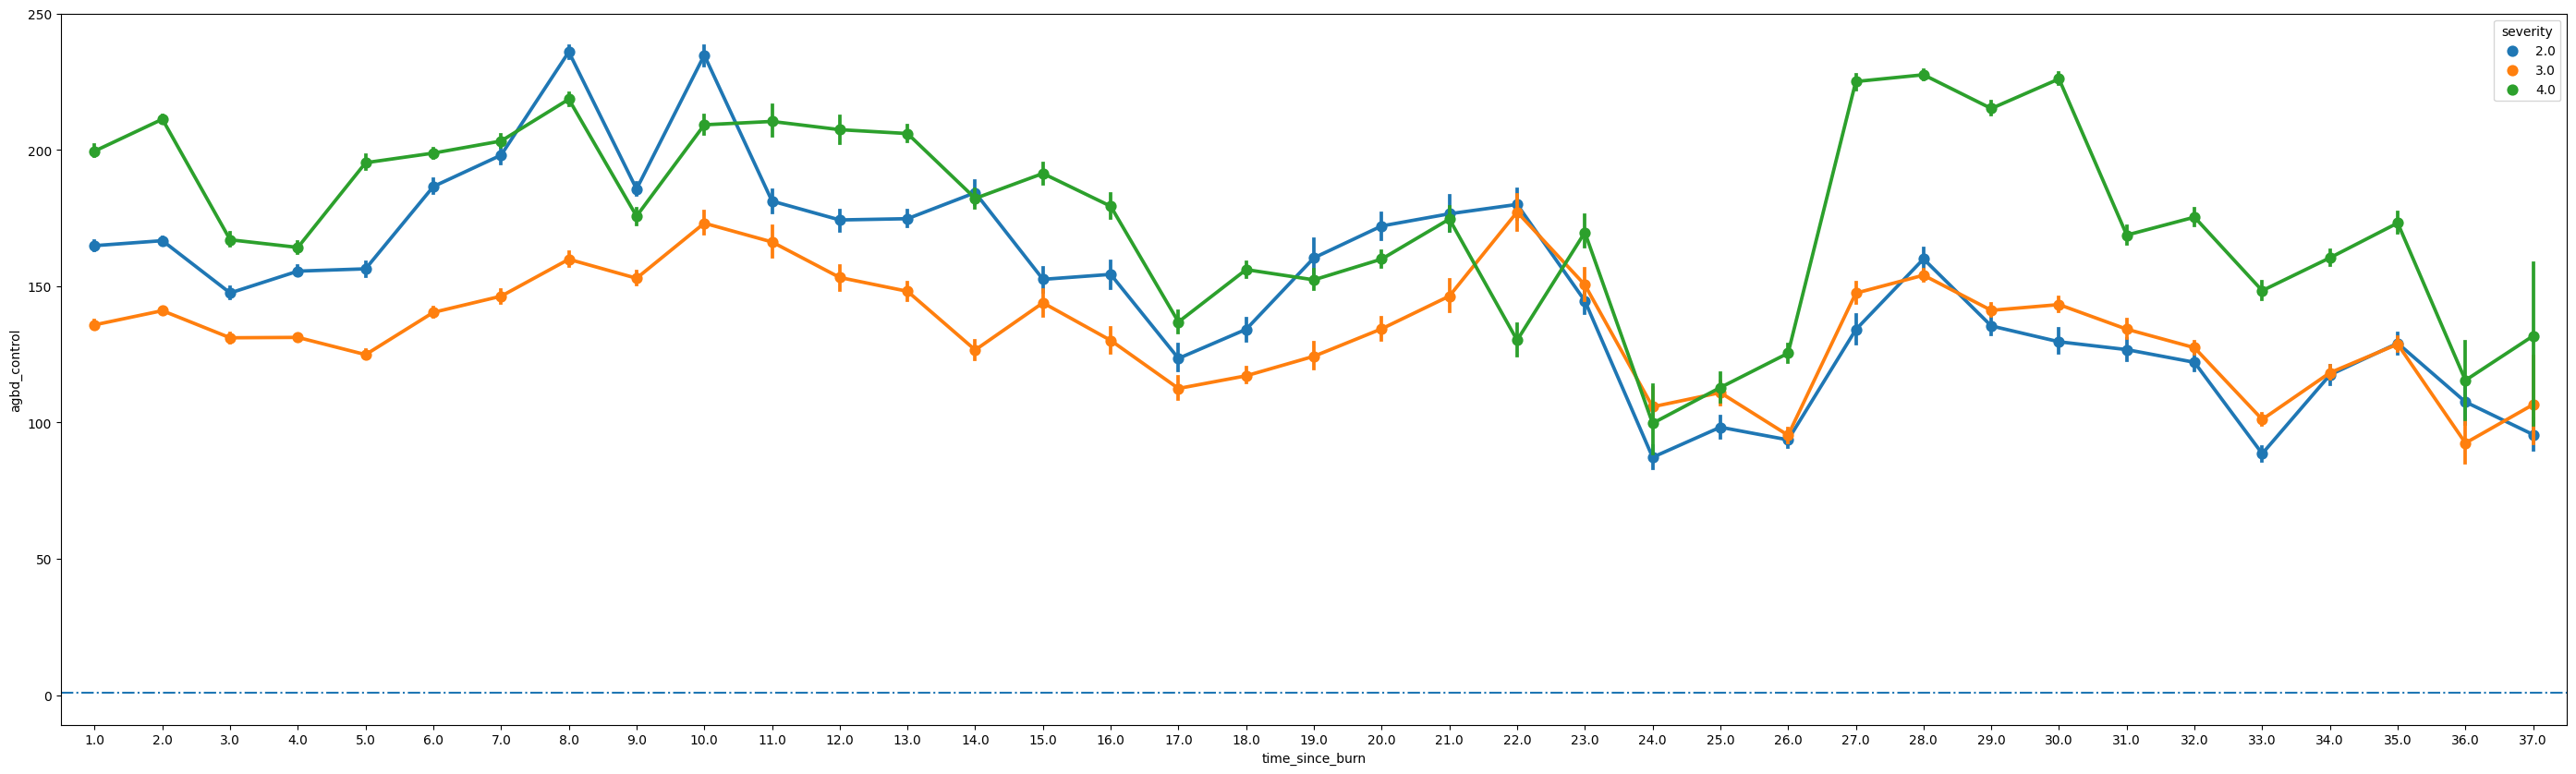

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_matched_2_trees, x='time_since_burn', y='agbd_control', hue='severity')
ax.axhline(y=1, linestyle="-.")

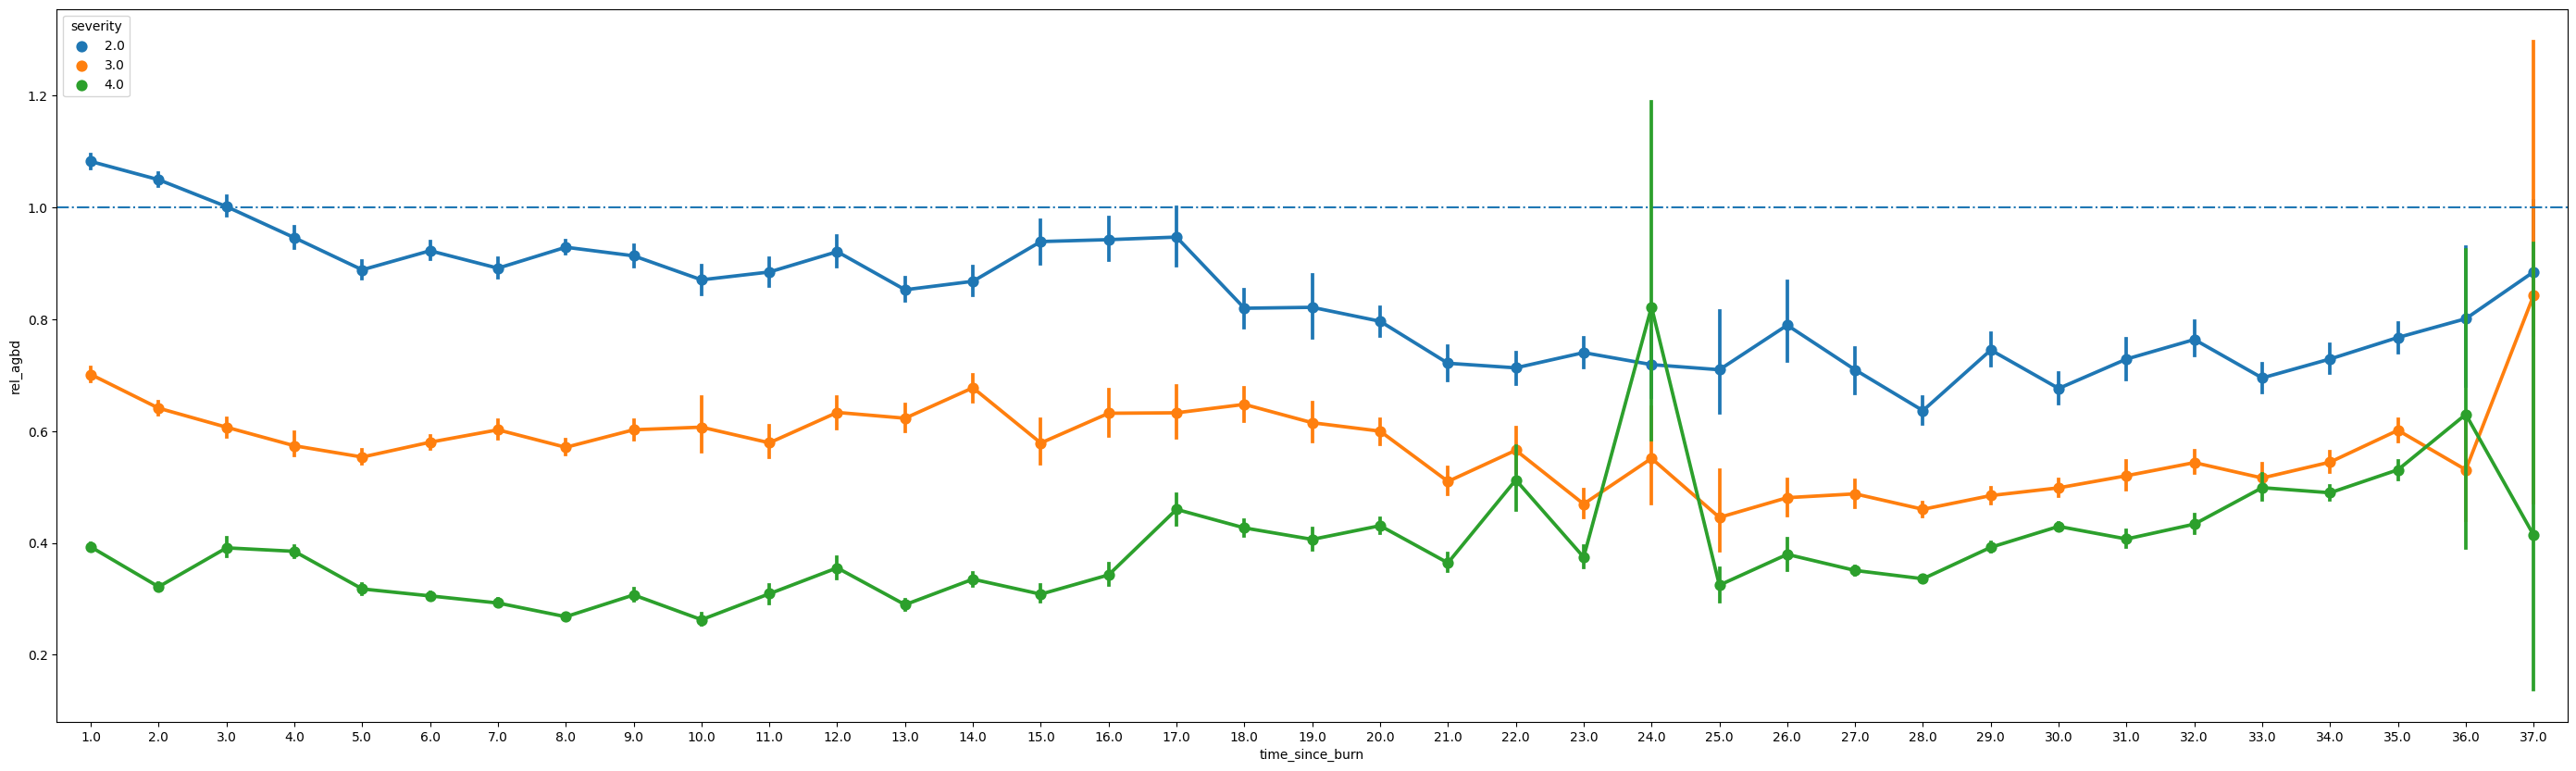

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_matched_2_trees, x='time_since_burn', y='rel_agbd', hue='severity')
ax.axhline(y=1, linestyle="-.")

In [23]:
gedi_matched_2_trees[gedi_matched_2_trees.time_since_burn == 27]

shot_number   longitude   latitude        agbd  \
2009754    28900600300590188 -120.507576  38.179015   61.934311   
2022105    28900800300235650 -120.511065  38.171417  107.579773   
2022112    28900800300235664 -120.504066  38.166787  100.781990   
2023646    28900800300235632 -120.520063  38.177344  112.817490   
2023649    28900800300235638 -120.517058  38.175349  137.951721   
...                      ...         ...        ...         ...   
22197725  179400100200078524 -120.714522  38.174184   15.642823   
22197731  179400200200083801 -120.714770  38.167493   73.073761   
22197734  179400200200083806 -120.712238  38.169157  113.251709   
22197783  191910500200119992 -120.715519  38.171699   32.176132   
22197860  225021100200119978 -120.712423  38.171811   14.902639   

          agbd_pi_lower  agbd_pi_upper    agbd_se beam_type  sensitivity  \
2009754        5.695565     178.306152  11.102563      full     0.964628   
2022105       23.907804     251.367493  11.099358      full     0.973771   
2022112       20.758692     240.928665  11.100762      full     0.950629   
2023646       26.410229     259.339722  11.099211      full     0.971803   
2023649       39.201389     296.854614  11.106153      full     0.978508   
...                 ...            ...        ...       ...          ...   
22197725   -9999.000000      89.136017  11.113858  coverage     0.950568   
22197731       9.392299     196.895706  11.103925  coverage     0.958226   
22197734      26.618568     260.003998  11.099983  coverage     0.971849   
22197783       0.035454     124.467705  11.105848      full     0.988401   
22197860   -9999.000000      87.358360  11.114223      full     0.953243   

          pft_class  ...  severity  burn_year burn_count time_since_burn  \
2009754           1  ...       3.0     1992.0        1.0            27.0   
2022105           1  ...       2.0     1992.0        1.0            27.0   
2022112           1  ...       2.0     1992.0        1.0            27.0   
2023646           1  ...       3.0     1992.0        1.0            27.0   
2023649           1  ...       2.0     1992.0        1.0            27.0   
...             ...  ...       ...        ...        ...             ...   
22197725          1  ...       2.0     1995.0        1.0            27.0   
22197731          1  ...       2.0     1995.0        1.0            27.0   
22197734          1  ...       3.0     1995.0        1.0            27.0   
22197783          1  ...       2.0     1995.0        1.0            27.0   
22197860          1  ...       2.0     1995.0        1.0            27.0   

          elevation  slope  aspect  soil  agbd_control  rel_agbd  
2009754      493.00  23.00  163.50   5.0    144.966857  0.427231  
2022105      650.50  20.50  176.00   5.0    138.048360  0.779290  
2022112      527.50  12.00  214.00   5.0    136.454094  0.738578  
2023646      615.50   9.00  206.50   5.0     90.114445  1.251936  
2023649      425.00   8.00  327.00   5.0    123.939581  1.113056  
...             ...    ...     ...   ...           ...       ...  
22197725     688.00  13.50  230.00   0.0     57.206462  0.273445  
22197731     558.25  18.50  265.00   0.0     75.200517  0.971719  
22197734     706.50  26.00  259.00   0.0     81.248721  1.393889  
22197783     600.50  21.00  242.50   0.0     79.729990  0.403564  
22197860     701.00  13.75  281.75   0.0     47.032251  0.316860  

[4809 rows x 24 columns]

In [38]:
filtered = gedi_matched_2_trees[(gedi_matched_2_trees.time_since_burn == 27) & (gedi_matched_2_trees.agbd_control > 200)]
filtered

shot_number   longitude   latitude        agbd  \
2499890    19581100300229937 -120.374480  38.777621   84.449303   
2499891    19581100300229939 -120.373461  38.776970   76.916794   
2499895    19581100300229944 -120.370905  38.775336  119.482811   
2499896    19581100300229947 -120.369372  38.774356  142.465103   
2499943    34050600200453745 -120.370719  38.772328  340.160309   
...                      ...         ...        ...         ...   
21987898  141320300300287812 -120.332767  38.059909  202.500824   
21988856  141320000300288974 -120.327224  38.075656  177.100082   
21988876  141320100300287852 -120.327648  38.068777  214.915009   
24486307  130950800300190631 -120.284972  39.574719   26.363438   
24642359  130951100300185343 -120.285576  39.568226   17.861290   

          agbd_pi_lower  agbd_pi_upper    agbd_se beam_type  sensitivity  \
2499890       13.741662     215.275955  11.099963      full     0.987020   
2499891       10.805129     203.157364  11.101789      full     0.983520   
2499895       29.676689     269.419617  11.102119      full     0.986525   
2499896       41.645100     303.402313  11.099630      full     0.986277   
2499943      167.767578     572.853394  11.133463      full     0.989626   
...                 ...            ...        ...       ...          ...   
21987898      76.515060     388.612946  11.101319  coverage     0.965594   
21988856      61.225586     353.105957  11.102240  coverage     0.967150   
21988876      84.187981     405.803284  11.107757  coverage     0.969211   
24486307   -9999.000000     112.763741  11.107406      full     0.984634   
24642359   -9999.000000      94.318283  11.111476      full     0.964663   

          pft_class  ...  severity  burn_year burn_count time_since_burn  \
2499890           1  ...       4.0     1992.0        1.0            27.0   
2499891           1  ...       4.0     1992.0        1.0            27.0   
2499895           1  ...       4.0     1992.0        1.0            27.0   
2499896           1  ...       4.0     1992.0        1.0            27.0   
2499943           1  ...       4.0     1992.0        1.0            27.0   
...             ...  ...       ...        ...        ...             ...   
21987898          1  ...       3.0     1994.0        1.0            27.0   
21988856          1  ...       2.0     1994.0        1.0            27.0   
21988876          1  ...       2.0     1994.0        1.0            27.0   
24486307          1  ...       4.0     1994.0        1.0            27.0   
24642359          1  ...       4.0     1994.0        1.0            27.0   

          elevation  slope  aspect  soil  agbd_control  rel_agbd  
2499890      1307.0  11.50  168.50   5.0    307.868227  0.274303  
2499891      1307.0  12.00  233.00   5.0    236.717804  0.324930  
2499895      1277.0  20.00  155.00   5.0    274.620323  0.435084  
2499896      1237.0   7.00  290.00   5.0    321.614461  0.442969  
2499943      1242.0  24.00  293.00   5.0    245.928909  1.383165  
...             ...    ...     ...   ...           ...       ...  
21987898      837.5  25.00  353.00   5.0    212.370961  0.953524  
21988856      738.0  26.00  167.00   5.0    227.574681  0.778206  
21988876      817.0  32.00    4.50   5.0    233.698757  0.919624  
24486307     1798.5  22.25  178.25   5.0    238.127625  0.110711  
24642359     1871.0  15.00   29.00   5.0    222.371498  0.080322  

[2195 rows x 24 columns]

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/geopandas/geodataframe.py:1475: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


<Axes: >

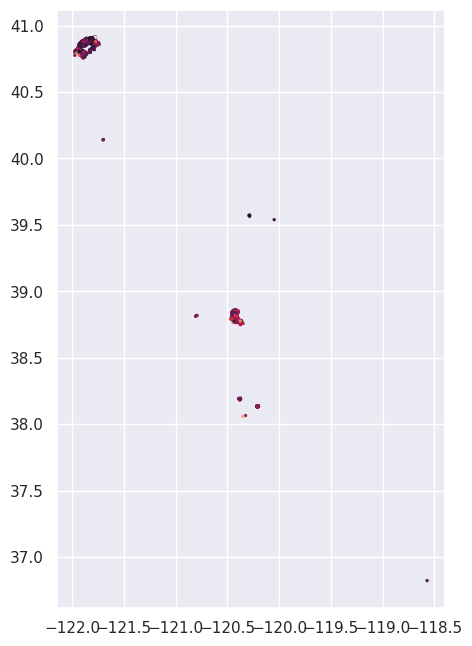

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(5, 15))
filtered[(gedi_matched_2_trees.severity == 4)].plot(column='rel_agbd', ax=ax, vmin=0, vmax=1, markersize=2)
#gedi_matched_2_trees[(gedi_matched_2_trees.time_since_burn == 27) & (gedi_matched_2_trees.severity == 3)].plot(ax=ax, color='green', alpha=0.5)

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/geopandas/geodataframe.py:1475: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


<Axes: >

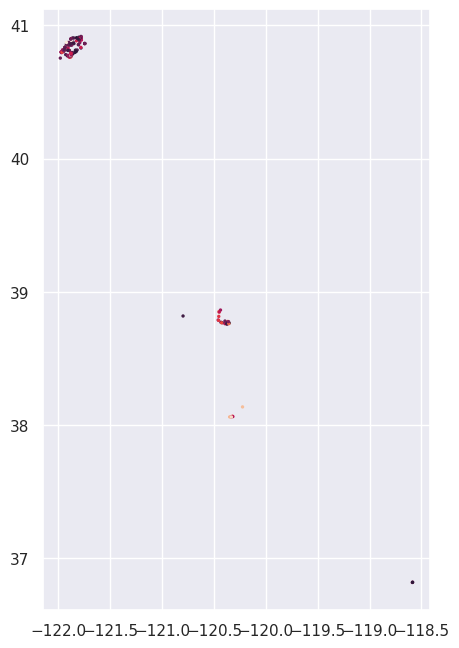

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5, 15))
filtered[(gedi_matched_2_trees.severity == 3)].plot(column='rel_agbd', ax=ax, vmin=0, vmax=1, markersize=2)
#gedi_matched_2_trees[(gedi_matched_2_trees.time_since_burn == 27) & (gedi_matched_2_trees.severity == 3)].plot(ax=ax, color='green', alpha=0.5)